# Machine Learning for disease diagnosis using omics data

## Discussion Agenda:


### 2. Items pending - haven't yet had time to complete but hope to complete:
    - Logistic regression
        - Calculation of Youden's statistic as a score for logistic regression model
        - Optimising the threshold to define the classes, for example based on maximising Youden's J statistic, balancing sensitivity and selectivity. Currently threshold set at the default probability of 0.5
    - XGBoost - updating the model to score based on out of bag metrics, and selecting a set number of features
    - Random Forest - test using Recursive Feature Elimination on the Random Forest to reduce the number of features used in the model
    - Logistic regression - optimising the threshold for predicting the classes, based on maximising Youden's J Statistic

- Try MRMR instead of just mutual information for the pre-selection of the features in SVM - https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b

- SVM - try alternative to Recursive feature elimination use sequential feature selection algorithm, again with a backward search, but using BIC probabalistic methods to score each model to determine the optimum balance of number of features and performance.

- Read why Random Forest is an embedded feature selection method. Apply Recursive feature elimination to the Random Forest model to select only 30 best features

- Additional Hyper parameter tuning and optimisation of Random Forest and XGBoost

- SVM - try alternative to Recursive feature elimination, where features are eliminated based on coefiients, and use a different function - sequential feature selection, again with a backward search, but using BIC probabalistic methods to score each model to determine the optimum balance of number of features and performance. Would do without cross validation, and just score on the train set.
- RF  - using select from model - https://medium.com/analytics-vidhya/feature-selection-embedded-methods-a7940036973f
- Determine whether calibration required before ROC plot for SVM / RF / XGBoost
- Clean & Integrate clinical data - requires some pre-processing
- Additional Hyper parameter tuning and optimisation of Random Forest and XGBoost
- Experiment with deep learning based feature selection methods from lit search


This file and raw data in github repo here: https://github.com/parkyed/sepsis_ml_omics_msc


# Code:

In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import KFold, RepeatedKFold
import warnings
from joblib import dump, load
from pickle import dump, load
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.")
#np.random.seed(1)


In [2]:
os.getcwd()

'/Users/Ed/Documents/GitHub/sepsis_ml_omics_msc'

### Data Import and Reformatting

In [263]:
# import and check data

raw_data = pd.read_csv('genomic_data.csv')
print('The number of columns is:  '+str(len(raw_data.columns)))
print('The number of row is:  '+str(len(raw_data)))

The number of columns is:  93
The number of row is:  48804


In [264]:
# Eliminate duplicate genes. Testing on various columns, NaN values excluded before looking for duplicates.

dup_column = ['NuID', 'Search_Key', 'ILMN_Gene', 'RefSeq_ID', 'Entrez_Gene_ID', 'Probe_Id']
for column in dup_column:
    data = raw_data.dropna(subset=[column])
    dup_list = []
    for index, value in data.duplicated(subset=[column]).items():
        if value == True:
            dup_list.append(index)
    print(f"# duplicate rows based on {column}:   "+str(len(dup_list)))

# duplicate rows based on NuID:   0
# duplicate rows based on Search_Key:   4671
# duplicate rows based on ILMN_Gene:   11000
# duplicate rows based on RefSeq_ID:   5742
# duplicate rows based on Entrez_Gene_ID:   10897
# duplicate rows based on Probe_Id:   1


In [265]:
# reformat data, drop duplicates, transpose, index on probe_id, drop columns with all NaN, drop Fold change

gene_df = raw_data.iloc[:, 0:29]
df = raw_data.iloc[:, np.r_[14, 29:93]].drop_duplicates(subset=['Probe_Id'])
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.drop(['Fold change'], axis=0)
df = df.dropna(axis=1, how='all')

labels = []
for item in df.index:
    if 'Con' in item:
        labels.append(0)
    else:
        labels.append(1)
labels = np.asarray(labels)

bool_series_zeros = (df == 0).all(axis=0)

print('Features:  '+str(len(df.columns)))
print('Examples:  '+str(len(df)))
print('Missing values:   '+str(df.isnull().sum().sum()))
print('The number of columns with all zeros is:   '+str(sum(bool_series_zeros)))
df.head()

Features:  48802
Examples:  63
Missing values:   0
The number of columns with all zeros is:   0


,ILMN_2227757,ILMN_1683690,ILMN_1710146,ILMN_1822171,ILMN_1748473,ILMN_1822843,ILMN_1710170,ILMN_1704497,ILMN_1847638,ILMN_1772260,...,ILMN_1712859,ILMN_1747129,ILMN_1813344,ILMN_2292576,ILMN_1793445,ILMN_2065273,ILMN_1800873,ILMN_1666642,ILMN_1908209,ILMN_1670343
Con_001,7.0713,7.0252,7.0713,7.0713,12.8555,7.0395,7.0252,7.0252,6.9692,7.1443,...,6.9278,7.0713,7.6728,7.0545,7.0103,7.0252,7.2258,7.3808,7.2626,6.9828
Con_017,7.0033,7.0436,7.0832,7.1232,12.5604,7.1232,7.0301,7.1486,6.9203,7.1865,...,7.0436,7.0164,8.1798,6.9896,6.9896,7.0963,7.0577,6.9492,7.0164,7.0301
Con_021,7.0907,7.0323,7.097,7.0824,12.5437,7.0583,7.0739,6.9975,6.9975,7.0405,...,7.097,7.0158,7.8981,7.0158,7.1521,7.0655,7.0824,6.9975,7.097,6.9892
Con_022b,7.0327,7.024,7.0419,7.024,12.0483,7.0766,7.0598,7.1015,6.9954,7.0055,...,7.1564,7.167,7.9036,6.9031,7.0598,6.9863,7.1625,7.1378,7.024,7.0327
Con_028,7.0057,6.9538,7.0308,7.0831,12.6549,6.9538,6.9538,7.1371,7.1512,7.264,...,7.0577,7.0057,8.2019,7.0308,7.0702,6.9799,7.0963,7.1512,7.2064,7.0186


In [266]:
# create copy of the data without patient Inf_075

df_no75 = df.drop(['Inf075'], axis=0)

# re-create labels
labels_no75 = []
for item in df.index:
    if item == 'Inf075':
        continue
    if 'Con' in item:
        labels_no75.append(0)
    else:
        labels_no75.append(1)
labels_no75 = np.asarray(labels_no75)
len(labels_no75)

# check it is correct
#list(zip(df_no75.index, labels_no75))
df_no75.shape

(62, 48802)

### Pre-Processing

1. **Standardisation** - Data standardised (i.e. z-scored) for the following reasons:
- L1 regularisation penalties in logistic regressions assumes data centred at zero and on the same scale
- Distance based ML models such as SVM require and assume standardised data, otherwise variables on larger scales disproportionally impact the model
- Am using the output coeffiecients from logistic regression as a crude measure of feature importance, and so in order to compare coefficients as a measure of relative importance, variables must be standardised

background - https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

2. **Train, test, split:** 66% train / 33% test

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


In [267]:
# standardise by imputing NaN values and using standard scale - z-scoring
# note - given imputer not necessary, could move standard scaler into the pipeline for each model

def standardise(examples):
    scaler = StandardScaler()
    examples_scaled = scaler.fit_transform(examples)
    return examples_scaled

X_df = standardise(df)
X_df = pd.DataFrame(X_df, columns=df.columns, index=df.index)
print(X_df.shape)

# dataset excluding patient 75
X_df_no75 = standardise(df_no75)
X_df_no75 = pd.DataFrame(X_df_no75, columns=df_no75.columns, index=df_no75.index)
print(X_df_no75.shape)

# Reduced dataset for code testing
X_df_red = X_df.iloc[:, 0:200]
print(X_df_red.shape)

(63, 48802)
(62, 48802)
(63, 200)


### Functions for model analysis

In [268]:
def score_model(y_pred_classes, y_pred_probabilities, y_true_classes):
    accuracy = round(accuracy_score(y_true_classes, y_pred_classes),2)
    recall = round(recall_score(y_true_classes, y_pred_classes),2)
    tn, fp, fn, tp = confusion_matrix(y_true_classes, y_pred_classes).ravel()
    specificity = round((tn / (tn+fp)),2)
    precision = round(precision_score(y_true_classes, y_pred_classes),2)
    auc = round(roc_auc_score(y_true_classes, y_pred_probabilities[:, 1]),2)
    return accuracy, recall, specificity, precision, auc

def score_model_no_auc(y_pred_classes, y_true_classes):
    accuracy = round(accuracy_score(y_true_classes, y_pred_classes),2)
    recall = round(recall_score(y_true_classes, y_pred_classes),2)
    tn, fp, fn, tp = confusion_matrix(y_true_classes, y_pred_classes).ravel()
    specificity = round((tn / (tn+fp)),2)
    precision = round(precision_score(y_true_classes, y_pred_classes),2) 
    return accuracy, recall, specificity, precision

def mis_class_points(X_test, y_pred_classes, y_true_classes):
    mis_classified = {}
    for row_index, (examples, prediction, label) in enumerate(zip (X_test, y_pred_classes, y_true_classes)):
        if prediction == label:
            continue
        if prediction == 0 and label == 1:
            mis_classified[X_test.iloc[[row_index]].index[0]] = 'fn'
        elif prediction == 1 and label == 0:
            mis_classified[X_test.iloc[[row_index]].index[0]] = 'fp'
    return mis_classified  

def plot_auc_cm(X_test, y_pred_classes, y_pred_probabilities, y_true_classes):
    build_roc_auc(y_pred_probabilities, y_true_classes)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_disp.plot(colorbar=False)

In [269]:
# function for building the ROC curve
# Code credit: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

def build_roc_auc(y_preds, y_test): #model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
    model - an sklearn instantiated model
    X_train - the training data
    y_train - the training response values
    X_test - the test data
    y_test - the test response values
    
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    
    #y_preds = model.fit(X_train, y_train).predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic plot')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))

### Functions to extract genes from final models and plot them

In [270]:
# select features and match to common gene names for models that output coefficients

from matplotlib import pyplot

# identify genes where model outputs coefficients

def identify_genes_from_coefs(selected_features, dataset, gene_df):
    selected_gene_list = list(zip(dataset.columns, selected_features))

    selected_gene_codes = []
    selected_gene_coefficients = []
    for gene in selected_gene_list:
        if gene[1] != 0:
            selected_gene_codes.append(gene[0])
            selected_gene_coefficients.append(gene[1])

    # identify common gene codes
    selected_gene_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes)].iloc[:, np.r_[14, 5]]
    selected_gene_codes_common = list(selected_gene_df.iloc[:,1])

    # zip features importances with common names

    selected_gene_final = list(zip(selected_gene_codes_common, selected_gene_coefficients))
    selected_gene_final = sorted(selected_gene_final, key = lambda x: x[1])
    
    return selected_gene_final, selected_gene_df

# function to extract genes using feature importances data

def select_genes_fi(selected_features, dataset, gene_df):

    selected_gene_list = list(zip(dataset.columns, selected_features))

    selected_gene_codes = []
    selected_gene_coefficients = []
    for gene in selected_gene_list:
        if gene[1] > 0:
            selected_gene_codes.append(gene[0])
            selected_gene_coefficients.append(gene[1])

    # identify common gene codes
    selected_gene_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes)].iloc[:, np.r_[14, 5]]
    selected_gene_codes_common = list(selected_gene_df.iloc[:,1])

    # zip features importances with common names

    selected_gene_final = list(zip(selected_gene_codes_common, selected_gene_coefficients))
    selected_gene_final = sorted(selected_gene_final, key = lambda x: x[1])
    
    return selected_gene_final

# plot_of genes vs. coefficients

def plot_genes(features_sorted, model):
    pyplot.bar(range(len(features_sorted)), [val[1] for val in features_sorted])
    pyplot.xticks(range(len(features_sorted)), [val[0] for val in features_sorted])
    plt.title(model)
    pyplot.xticks(rotation=70)

### Classifier 1: Logistic Regression

- L1 regularised logistic regression. L1 used given we know that a large number of feature are irrelevant, hence L1 / Lasso regularisation acts as form of feature selection. L1 required the liblinear solver.
- L1 - Lasso - regularisation is an embedded feature selection method, therefore no additional feature selection implemented.
- Discussion of FS methods - https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/
- Nested cross validation used given the low sample size, and potential high variance in the output data
- code credit: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
- Source / ref: avoiding common pitfalls in machine learning omic data science paper
- Performed with Leave One Out cross-validation - i.e. n folds - on the regularisation parameter C. Given small samples size, LOO provides the least biased model, the most accurate estimate of model performance, as every training example is used as a validation set.
https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/
- Had previously tried 5-fold cross validation - but loo improved the performance. Mention, and explain why.


### Hyper-parameter optimisation - Baysian optimisation with Gaussian Processes

- The grid search of the logistic regression hyper parameter C is time consuming and slow, potentially testing a large number of useless and poorly performing parameters. May also result in high variance of the outcome over multiple train/ test splits (reference literature)
- Using Baysian optimisation with Gaussian Processes as a more computationally efficient, and more rigerous process to determine the optimum value of C.
- Manually coded the inner cross validation loop - to be able to store the predictions for each fold, and then calculate a score for the value of C, using the set of y-hat and y-val across all 42 folds. Built in CV assumes larger samples sizes with say 5 fold, and calculates a score on each fold and averages - doesn't allow to do recall / precision given could have zero demoniators. 
- Logistic regression with lasso - an embedded feature selection reduces features from 48,000 down to 200-300 features. Good, but ideally want a model that performs equally well, but is able to identify the best 5-10 feature - i.e. stronger penalties in place for useless features. However want to use an approach that involves fitting models, and not filtering based on linear relationships with the output variable. E.g. not Kbest or filter methods, given problems of co-linearity (see slide deck). Therefore looking at SVM-RFE, and regularised tree based models. And SVM with SFS using BIC???
- code credit - https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
- code credit - https://scikit-optimize.github.io/stable/modules/generated/skopt.utils.use_named_args.html
- code credit - https://towardsdatascience.com/optimizing-hyperparameters-the-right-way-3c9cafc279cc
- ref: https://scikit-optimize.github.io/stable/modules/generated/skopt.optimizer.gp_minimize.html#skopt.optimizer.gp_minimize


### i. LR - Optimise for performance, regardless of number of features

In [271]:
from sklearn.model_selection import RepeatedKFold, LeaveOneOut
from sklearn.linear_model import LogisticRegression
import skopt
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_evaluations
from math import log
from matplotlib import pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before")

def nested_cv_lr(df, labels, n_repeats):

    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []
    selected_features_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        model, best_parameter = train_lr_baysian(X_train, y_train)

        # predict on the test set and store the selected features
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)
        
        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        selected_features = model.coef_[0]

        # add scores for this train test split to lists collecting scores for all splits
        scores_list.append(scores)
        best_parameters_list.append(best_parameter)
        mis_classified_list.append(mis_classified)
        selected_features_list.append(selected_features)

    return scores_list, best_parameters_list, mis_classified_list, selected_features_list

def train_lr_baysian(X_train, y_train):
    # define cross validation approach
    cv_inner = LeaveOneOut()

    # define hyper paramaeter search space
    hyper_p_c = Real(low=1e-6, high=1000.0, prior='log-uniform', name='C')
    search_space_lr = [hyper_p_c]

    # define the objective function to optimise over the hyper-parameter search space. Here we want to minimise 1- the 
    # accuracy score - balancing recall and precision in the model.
    @use_named_args(search_space_lr)
    def evaluate_model(**params):
        cv_inner = LeaveOneOut()
        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]         
       
            # define the model
            model = LogisticRegression(penalty='l1', solver="liblinear")
            model.set_params(**params)
            model.fit(X_train_inner, y_train_inner)

            y_val_pred = model.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)
            
        score = accuracy_score(y_val_classes, y_val_predictions)
        return 1.0 - score

    # perform optimization
    result = gp_minimize(evaluate_model, search_space_lr, acq_func="EI", x0=[1.0], n_initial_points=20, n_calls=30)

    # save the best performing value of hyper parameter C
    best_parameter = result.x
    print('Best Parameters: %s' % (result.x))
    print('Best Score: %.3f' % (1.0 - result.fun))

    
    # retrain the model with fixed value of C
    model = LogisticRegression(C=best_parameter[0],
                                  penalty='l1',
                                  solver="liblinear")
    model.fit(X_train, y_train)

    return model, best_parameter

Best Parameters: [862.4379416724919]
Best Score: 0.952
Best Parameters: [1.0]
Best Score: 0.952
Best Parameters: [1.0]
Best Score: 1.000
The results for logistic regression test examples:
[(0.95, 1.0, 0.92, 0.89, 0.94), (0.86, 1.0, 0.75, 0.75, 0.95), (0.86, 0.73, 1.0, 1.0, 0.97)]
[[862.4379416724919], [1.0], [1.0]]
[0.89       0.91       0.89       0.88       0.95333333]
[{'Con_079': 'fp'}, {'Con_096a': 'fp', 'Con_165a': 'fp', 'Con_181a': 'fp'}, {'Inf075': 'fn', 'Inf_114': 'fn', 'Inf_119': 'fn'}]


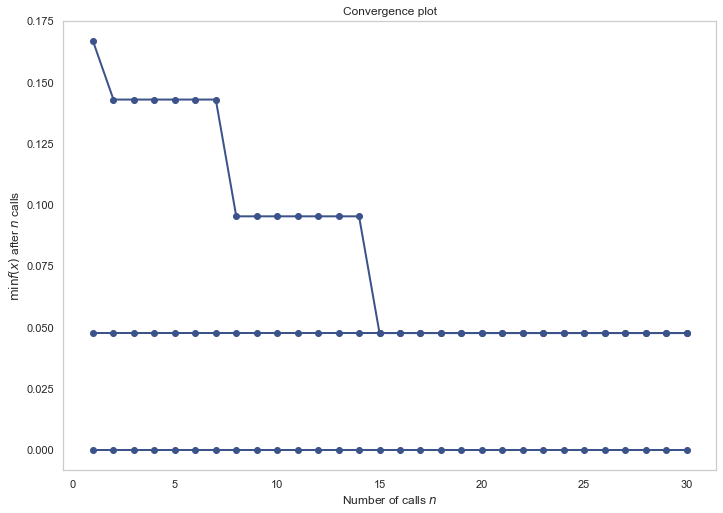

In [293]:
# run nested cross validation on test data set
scores_lr_red, best_parameters_lr_red, mis_classified_lr_red, selected_features_list_lr_red = nested_cv_lr(X_df_red, labels, 1)

# print results
print('The results for logistic regression test examples:')
print(scores_lr_red)
print(best_parameters_lr_red)
print(np.mean(np.asarray(scores_lr_red), axis=0))
print(mis_classified_lr_red)

Best Parameters: [1.0]
Best Score: 0.976
Best Parameters: [0.08228844256425769]
Best Score: 1.000
Best Parameters: [34.879632734662266]
Best Score: 0.952
Best Parameters: [1.0]
Best Score: 1.000
Best Parameters: [1.2789088991773574]
Best Score: 1.000
Best Parameters: [5.478667394027816]
Best Score: 0.976
Best Parameters: [0.09070443334341415]
Best Score: 0.952
Best Parameters: [12.164923684430583]
Best Score: 0.976
Best Parameters: [1.0]
Best Score: 1.000


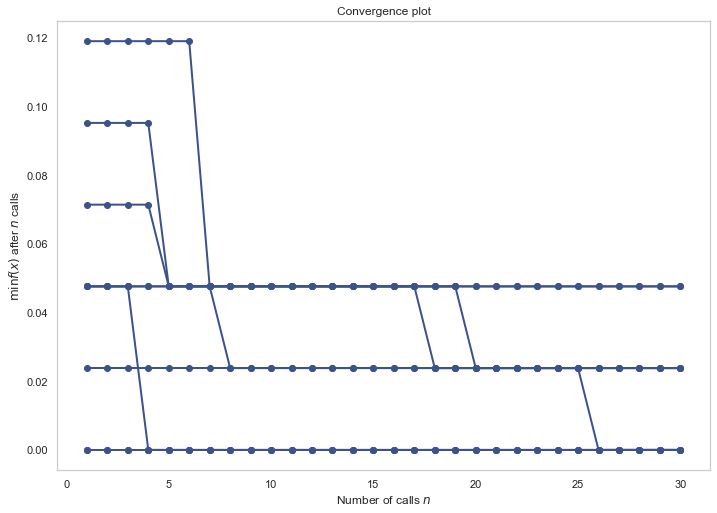

In [381]:
# run optimisations on full dataset (including patient 75)

scores_lr, best_parameters_lr, mis_classified_lr, selected_features_list_lr = nested_cv_lr(X_df,  labels, 3)

In [399]:
# create datafrom from the results - including the number of selected features each iteration

def lr_results_df_inc_features(scores, parameters, misclassified, features):
    p_list = []
    for i in parameters:
        p_list.extend(i)
    p_list = np.array(p_list)
    p_list = np.around(p_list, decimals=2)
    p_list = np.append(p_list, ['n/a'], axis=0)
    mean_scores = np.mean(np.asarray(scores), axis=0)
    array = np.array(scores)
    array = np.vstack((array, mean_scores))
    array = pd.DataFrame(array, index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 'Mean'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])
    # FOR TESTING array = pd.DataFrame(array, index = [1, 2, 3, 'Total'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])

    array = array.round(2)
    array.insert(0, 'Best C', p_list)

    # create column for the number of features
    feat_count_list = []
    for i in features:
        feat_count = np.count_nonzero(i)
        feat_count_list.append(feat_count)
    feat_count_list = np.append(feat_count_list, [str(round(np.mean(feat_count_list),0))], axis=0)
    feat_count_list = np.array(feat_count_list)
    array.insert(1, 'Num Features', feat_count_list)
    
    # create columns for false positives and false negatives
    fp_column = []
    fn_column = []
    for i in misclassified:
        fps = []
        fns = []
        for key, val in i.items():
            if val == 'fp':
                fps.append(key)
            if val == 'fn':
                fns.append(key)
        fp_column.append(fps)
        fn_column.append(fns)
    fp_column.append('n/a')
    fn_column.append('n/a')
    array.insert(7, 'False Positives', fp_column)
    array.insert(8, 'False Negatives', fn_column) 
    
    return array

In [291]:
lr_results_testing = lr_results_df_inc_features(scores_lr_red, best_parameters_lr_red, mis_classified_lr_red, selected_features_list_lr_red)
lr_results_testing

,Best C,Num Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,289.38,30,0.90,1.00,0.82,0.83,0.96,"[Con_165a, Con_181a]",[]
2,0.24,4,0.95,0.90,1.00,1.00,1.00,[],[Inf_149]
3,122.0,30,0.95,0.88,1.00,1.00,0.96,[],[Inf075]
Total,n/a,n/a,0.93,0.93,0.94,0.94,0.97,n/a,n/a


In [400]:
# create dataframe of results including patient 75
lr_results_df_all_inc75 = lr_results_df_inc_features(scores_lr, best_parameters_lr, mis_classified_lr, selected_features_list_lr)
lr_results_df_all_inc75 = lr_results_df_all_inc75.drop(['False Positives', 'False Negatives'], axis=1) 
lr_results_df_all_inc75

,Best C,Num Features,Accuracy,Recall,Specificity,Precision,AUC
1,1.0,101,0.95,0.88,1.00,1.00,0.98
2,0.08,2,0.90,1.00,0.82,0.83,0.98
3,34.88,210,0.95,1.00,0.91,0.91,1.00
4,1.0,68,0.81,1.00,0.67,0.69,0.91
5,1.28,91,0.95,0.89,1.00,1.00,0.95
6,5.48,139,1.00,1.00,1.00,1.00,1.00
7,0.09,4,0.90,1.00,0.78,0.86,1.00
8,12.16,177,1.00,1.00,1.00,1.00,1.00
9,1.0,64,0.90,0.90,0.91,0.90,0.98
Mean,n/a,95.0,0.93,0.96,0.90,0.91,0.98


In [393]:
# produce the LaTex code:

with open('lr_results_table_all_inc75.tex','w') as tf:
    tf.write(lr_results_df_all_inc75.to_latex())


Best Parameters: [1.0]
Best Score: 0.968


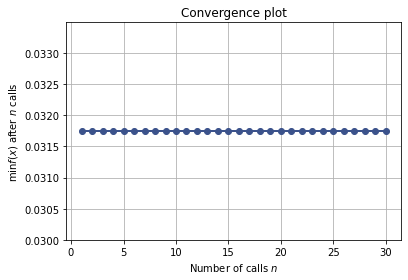

In [354]:
# train final model and determine features

final_lr, best_param = train_lr_baysian(X_df, labels)

In [391]:
# select features and match to common gene names

selected_features_lr = final_lr.coef_[0]
selected_gene_lr_final, selected_gene_lr_df = identify_genes_from_coefs(selected_features_lr, X_df, gene_df)


In [392]:
print('The number of selected genes is:  '+str(len(selected_gene_lr_final)))
#plot_genes(selected_gene_lr_final, model='logistic regression')

The number of selected genes is:  336


In [382]:
# saving down results of the model

with open('lr_results.pkl', 'wb') as f:
    pickle.dump([scores_lr, best_parameters_lr, mis_classified_lr, selected_features_list_lr], f)

In [92]:
#with open('lr_results.pkl', 'rb') as f:
#    scores_lr, best_parameters_lr, mis_classified_lr, selected_features_lr = pickle.load(f)

In [971]:
with open('lr_final_model.pkl', 'wb') as f:
    pickle.dump([final_lr, best_param], f)

In [390]:
with open('lr_final_model.pkl', 'rb') as f:
    final_lr, best_param = pickle.load(f)

### ii. LR - Optimise for a fixed number of features

In [341]:
# alternative optimisation function to solve for a fixed number of features

def nested_cv_lr_nf(df, labels, n_repeats, n_features):

    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []
    predictions_list = []
    selected_features_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        model, best_parameter = train_lr_baysian_nf(X_train, y_train, n_features)

        # predict on the test set and store the selected features
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)
  
        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        selected_features = model.coef_[0]

        # add scores for this train test split to lists collecting scores for all splits
        scores_list.append(scores)
        best_parameters_list.append(best_parameter)
        mis_classified_list.append(mis_classified)
        predictions_list.append((y_pred, y_pred_probab, y_test))
        selected_features_list.append(selected_features)
   
    return scores_list, best_parameters_list, mis_classified_list, predictions_list, selected_features_list

# could count the coefficients at each round as well

def train_lr_baysian_nf(X_train, y_train, n_features):

    # define hyper paramaeter search space
    hyper_p_c = Real(low=1e-6, high=1000.0, prior='log-uniform', name='C')
    search_space_lr = [hyper_p_c]
    target_features = n_features

    # define the objective function to optimise over the hyper-parameter search space.
    @use_named_args(search_space_lr)
    def evaluate_model(**params):
        # define the model
        model = LogisticRegression(penalty='l1', solver="liblinear")
        model.set_params(**params)
        model.fit(X_train, y_train)

        n_nonzero = np.sum(model.coef_ != 0)
        return (target_features-n_nonzero)**2

    # perform optimization
    result = gp_minimize(evaluate_model, search_space_lr, acq_func="EI", x0=[1.0], n_initial_points=20, n_calls=30)

    # save the best performing value of hyper parameter C
    best_parameter = result.x
    print('Best Parameters: %s' % (result.x))
    plot_convergence(result)
    plt.savefig("lr_best_features_nf.jpeg")

    # retrain the model with fixed value of C
    model = LogisticRegression(C=best_parameter[0],
                                  penalty='l1',
                                  solver="liblinear")
    model.fit(X_train, y_train)

    return model, best_parameter


In [337]:
# run nested cross validation on test data set
#scores_lr_nf_test, best_parameters_lr_nf_test, mis_classified_lr_nf_test, predictions_list_lr_nf_test, selected_features_list_lr_nf_test = nested_cv_lr_nf(X_df_red, labels, 1, 30)

#print('The results for logistic regression test examples:')
#print(scores_lr_nf_test)
#print(best_parameters_lr_nf_test)
#print(np.mean(np.asarray(scores_lr_nf_test), axis=0))
#print(mis_classified_lr_nf_test)
#print(predictions_list_lr_nf_test)

results for all examples with 30 features:
Best Parameters: [0.4021625209245782]
Best Parameters: [0.2748837836119871]
Best Parameters: [0.21488763676827902]
Best Parameters: [0.1909899356653439]
Best Parameters: [0.2720377410474035]
Best Parameters: [0.449794128484974]
Best Parameters: [0.14846120223302733]
Best Parameters: [0.24486403370689933]
Best Parameters: [0.34025202013336453]

results for examples excluding patient 75, with 3, 4, 5, 6, 7, 8, 9,10,15,20, 25 and 30 features:
Best Parameters: [0.1820010574531559]
Best Parameters: [0.12957040003665313]
Best Parameters: [0.12115303183857559]
Best Parameters: [0.33437663674274015]
Best Parameters: [0.2320807404552989]
Best Parameters: [0.22615370439065946]
Best Parameters: [0.4450670808828283]
Best Parameters: [0.14175512486250932]
Best Parameters: [0.26242038106799775]
Best Parameters: [0.13800212496173003]
Best Parameters: [0.3304290797928177]
Best Parameters: [0.16050568914030797]
Best Parameters: [0.31729602951391556]
Best Param

/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [4.4351977137748315e-05]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [0.05680573485589282]
Best Parameters: [0.1044533474884436]
Best Parameters: [0.09731329619359996]
Best Parameters: [0.07701688146037144]
Best Parameters: [0.09170850118132388]
Best Parameters: [0.06327364739489268]
Best Parameters: [0.08020405675074177]
Best Parameters: [0.07796881797129213]
Best Parameters: [0.09809371344095953]
Best Parameters: [0.05601687861033496]
Best Parameters: [0.05320465796352]
Best Parameters: [0.07373207483891998]
Best Parameters: [0.08958857684816388]
Best Parameters: [0.04961306952719405]
Best Parameters: [0.07783370639114769]
Best Parameters: [0.021918331774795997]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [0.07616760614335058]
Best Parameters: [0.08400463158712605]
Best Parameters: [0.10608134345717204]
Best Parameters: [0.05496375385839318]
Best Parameters: [0.06044710703421012]
Best Parameters: [0.10182728171563381]
Best Parameters: [0.06467690891326165]
Best Parameters: [0.06076012531039378]
Best Parameters: [0.07405014450995391]
Best Parameters: [0.0719582037827394]
Best Parameters: [0.07091147541725658]
Best Parameters: [0.056446239947764286]
Best Parameters: [1.4113669423738327e-05]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [1.9032921225057094e-05]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [0.06871567677100053]
Best Parameters: [0.013411918253329077]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [0.09644334741705006]
Best Parameters: [2.1010226788629245e-05]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [1.7939977039236843e-06]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [0.00018414757579078214]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [2.9280628487727425e-06]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Parameters: [1.6930589101949065e-05]


/Users/Ed/Anaconda/anaconda3/envs/keras_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


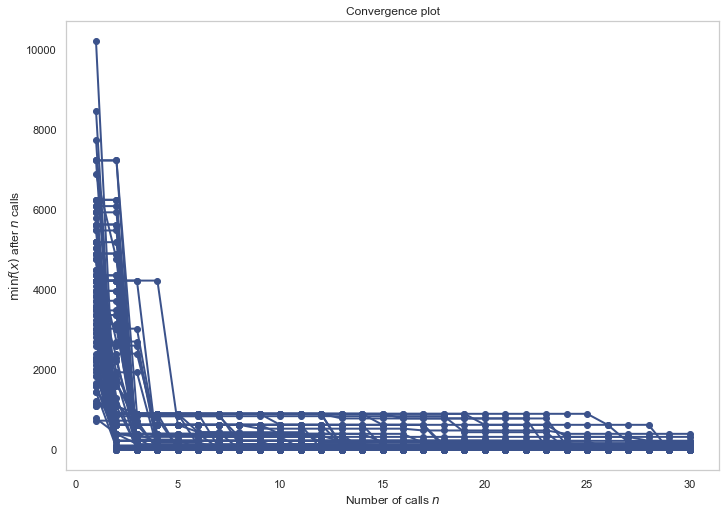

In [344]:
# run optimisations on full data sets

# run nested cross validation on full data set, 30 features
print("results for all examples with 30 features:")
scores_lr_nf, best_parameters_lr_nf, mis_classified_lr_nf, predictions_list_lr_nf, selected_features_list_lr_nf = nested_cv_lr_nf(X_df,  labels, 3, 30)

# run nested cross validation without patient 75
print("\nresults for examples excluding patient 75, with 3, 4, 5, 6, 7, 8, 9,10,15,20, 25 and 30 features:")
scores_lr_no75_30f, best_parameters_lr_no75_30f, mis_classified_lr_no75_30f, predictions_list_lr_no75_30f, selected_features_list_lr_no75_30f = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 30)
scores_lr_no75_25f, best_parameters_lr_no75_25f, mis_classified_lr_no75_25f, predictions_list_lr_no75_25f, selected_features_list_lr_no75_25f = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 25)
scores_lr_no75_20f, best_parameters_lr_no75_20f, mis_classified_lr_no75_20f, predictions_list_lr_no75_20f, selected_features_list_lr_no75_20f = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 20)
scores_lr_no75_15f, best_parameters_lr_no75_15f, mis_classified_lr_no75_15f, predictions_list_lr_no75_15f, selected_features_list_lr_no75_15f = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 15)
scores_lr_no75_10f, best_parameters_lr_no75_10f, mis_classified_lr_no75_10f, predictions_list_lr_no75_10f, selected_features_list_lr_no75_10f = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 10)
scores_lr_no75_9f,  best_parameters_lr_no75_9f,  mis_classified_lr_no75_9f,  predictions_list_lr_no75_9f,  selected_features_list_lr_no75_9f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 9)
scores_lr_no75_8f,  best_parameters_lr_no75_8f,  mis_classified_lr_no75_8f,  predictions_list_lr_no75_8f,  selected_features_list_lr_no75_8f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 8)
scores_lr_no75_7f,  best_parameters_lr_no75_7f,  mis_classified_lr_no75_7f,  predictions_list_lr_no75_7f,  selected_features_list_lr_no75_7f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 7)
scores_lr_no75_6f,  best_parameters_lr_no75_6f,  mis_classified_lr_no75_6f,  predictions_list_lr_no75_6f,  selected_features_list_lr_no75_6f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 6)
scores_lr_no75_5f,  best_parameters_lr_no75_5f,  mis_classified_lr_no75_5f,  predictions_list_lr_no75_5f,  selected_features_list_lr_no75_5f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 5)
scores_lr_no75_4f,  best_parameters_lr_no75_4f,  mis_classified_lr_no75_4f,  predictions_list_lr_no75_4f,  selected_features_list_lr_no75_4f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 4)
scores_lr_no75_3f,  best_parameters_lr_no75_3f,  mis_classified_lr_no75_3f,  predictions_list_lr_no75_3f,  selected_features_list_lr_no75_3f  = nested_cv_lr_nf(X_df_no75, labels_no75, 3, 3)


In [17]:
# create datafrom from the results:

def lr_results_df(scores, parameters, misclassified):
    p_list = []
    for i in parameters:
        p_list.extend(i)
    p_list = np.array(p_list)
    p_list = np.around(p_list, decimals=2)
    p_list = np.append(p_list, ['n/a'], axis=0)
    mean_scores = np.mean(np.asarray(scores), axis=0)
    array = np.array(scores)
    array = np.vstack((array, mean_scores))
    array = pd.DataFrame(array, index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 'Total'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])
    array = array.round(2)
    array.insert(0, 'Best C', p_list)

    # create columns for false positives and false negatives
    fp_column = []
    fn_column = []
    for i in misclassified:
        fps = []
        fns = []
        for key, val in i.items():
            if val == 'fp':
                fps.append(key)
            if val == 'fn':
                fns.append(key)
        fp_column.append(fps)
        fn_column.append(fns)
    fp_column.append('n/a')
    fn_column.append('n/a')
    array.insert(6, 'False Positives', fp_column)
    array.insert(7, 'False Negatives', fn_column) 
    
    return array

In [401]:
# create dataframes of the results, all patients, 30 features
lr_results_df_nf_inc75 = lr_results_df_inc_features(scores_lr_nf, best_parameters_lr_nf, mis_classified_lr_nf, selected_features_list_lr_nf)
lr_results_df_nf_inc75

,Best C,Num Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,0.4,49,0.95,0.83,1.00,1.00,0.98,[],[Inf_149]
2,0.27,33,0.90,0.88,0.92,0.88,0.99,[Con_165a],[Inf075]
3,0.21,24,0.95,1.00,0.86,0.93,1.00,[Con_206],[]
4,0.19,24,0.95,1.00,0.92,0.89,0.98,[Con_165a],[]
5,0.27,39,0.95,0.80,1.00,1.00,0.98,[],[Inf_149]
6,0.45,38,0.95,0.93,1.00,1.00,0.99,[],[Inf075]
7,0.15,14,1.00,1.00,1.00,1.00,1.00,[],[]
8,0.24,31,0.86,0.88,0.85,0.78,0.94,"[Con_165a, Con_206]",[Inf075]
9,0.34,38,1.00,1.00,1.00,1.00,1.00,[],[]
Mean,n/a,32.0,0.95,0.92,0.95,0.94,0.98,n/a,n/a


In [402]:
# results with no patient 75, 30 features
lr_results_df_nf_no75_30f = lr_results_df_inc_features(scores_lr_no75_30f, best_parameters_lr_no75_30f, mis_classified_lr_no75_30f, selected_features_list_lr_no75_30f)
lr_results_df_nf_no75_30f

,Best C,Num Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,0.18,21,1.00,1.0,1.00,1.00,1.0,[],[]
2,0.13,21,0.95,1.0,0.93,0.88,1.0,[Con_206],[]
3,0.12,12,0.95,1.0,0.92,0.89,1.0,[Con_165a],[]
4,0.33,29,1.00,1.0,1.00,1.00,1.0,[],[]
5,0.23,31,1.00,1.0,1.00,1.00,1.0,[],[]
6,0.23,34,1.00,1.0,1.00,1.00,1.0,[],[]
7,0.45,36,0.95,1.0,0.93,0.86,1.0,[Con_165a],[]
8,0.14,15,1.00,1.0,1.00,1.00,1.0,[],[]
9,0.26,47,1.00,1.0,1.00,1.00,1.0,[],[]
Mean,n/a,27.0,0.98,1.0,0.98,0.96,1.0,n/a,n/a


In [427]:
# results with no patient 75, 6 features
lr_df_30f = lr_results_df_inc_features(scores_lr_no75_30f, best_parameters_lr_no75_30f, mis_classified_lr_no75_30f, selected_features_list_lr_no75_30f)
lr_df_25f = lr_results_df_inc_features(scores_lr_no75_25f, best_parameters_lr_no75_25f, mis_classified_lr_no75_25f, selected_features_list_lr_no75_25f)
lr_df_20f = lr_results_df_inc_features(scores_lr_no75_20f, best_parameters_lr_no75_20f, mis_classified_lr_no75_20f, selected_features_list_lr_no75_20f)
lr_df_15f = lr_results_df_inc_features(scores_lr_no75_15f, best_parameters_lr_no75_15f, mis_classified_lr_no75_15f, selected_features_list_lr_no75_15f)
lr_df_10f = lr_results_df_inc_features(scores_lr_no75_10f, best_parameters_lr_no75_10f, mis_classified_lr_no75_10f, selected_features_list_lr_no75_10f)
lr_df_9f = lr_results_df_inc_features(scores_lr_no75_9f,  best_parameters_lr_no75_9f,  mis_classified_lr_no75_9f,  selected_features_list_lr_no75_9f)
lr_df_8f = lr_results_df_inc_features(scores_lr_no75_8f,  best_parameters_lr_no75_8f,  mis_classified_lr_no75_8f,  selected_features_list_lr_no75_8f)
lr_df_7f = lr_results_df_inc_features(scores_lr_no75_7f,  best_parameters_lr_no75_7f,  mis_classified_lr_no75_7f,  selected_features_list_lr_no75_7f)
lr_df_6f = lr_results_df_inc_features(scores_lr_no75_6f,  best_parameters_lr_no75_6f,  mis_classified_lr_no75_6f,  selected_features_list_lr_no75_6f)
lr_df_5f = lr_results_df_inc_features(scores_lr_no75_5f,  best_parameters_lr_no75_5f,  mis_classified_lr_no75_5f,  selected_features_list_lr_no75_5f)
lr_df_4f = lr_results_df_inc_features(scores_lr_no75_4f,  best_parameters_lr_no75_4f,  mis_classified_lr_no75_4f,  selected_features_list_lr_no75_4f)
lr_df_3f = lr_results_df_inc_features(scores_lr_no75_3f,  best_parameters_lr_no75_3f,  mis_classified_lr_no75_3f,  selected_features_list_lr_no75_3f)

In [490]:
# putting results into a dataframe
lr_results_frames = [lr_df_30f,lr_df_25f,lr_df_20f,lr_df_15f,lr_df_10f,lr_df_9f,lr_df_8f,lr_df_7f,lr_df_6f,lr_df_5f,lr_df_4f,lr_df_3f]

lr_aucs =[]
lr_avg_feat=[]
lr_mm_range = []
for df in lr_results_frames:
    lr_aucs.append(df['AUC'].values[-1])
    lr_avg_feat.append(df['Num Features'].values[-1])
data = np.vstack((lr_aucs, lr_avg_feat))
data = np.transpose(data)
lr_perf_features = pd.DataFrame(data=data, index=[30,25,20,15,10,9,8,7,6,5,4,3], columns=['AUC', 'Mean Features'])
lr_perf_features

,AUC,Mean Features
30,1.0,27.0
25,0.99,22.0
20,1.0,18.0
15,1.0,15.0
10,1.0,9.0
9,1.0,10.0
8,0.99,9.0
7,0.88,5.0
6,0.99,6.0
5,0.93,4.0


In [406]:
# produce the LaTex code:

with open('lr_results_table_nf_inc75.tex','w') as tf:
    tf.write(lr_results_df_nf_inc75.to_latex())
    
with open('lr_results_table_nf_no75_30f.tex','w') as tf:
    tf.write(lr_results_df_nf_no75_30f.to_latex())

### LR: Final Model Retraining

Best Parameters: [0.07885591671174019]


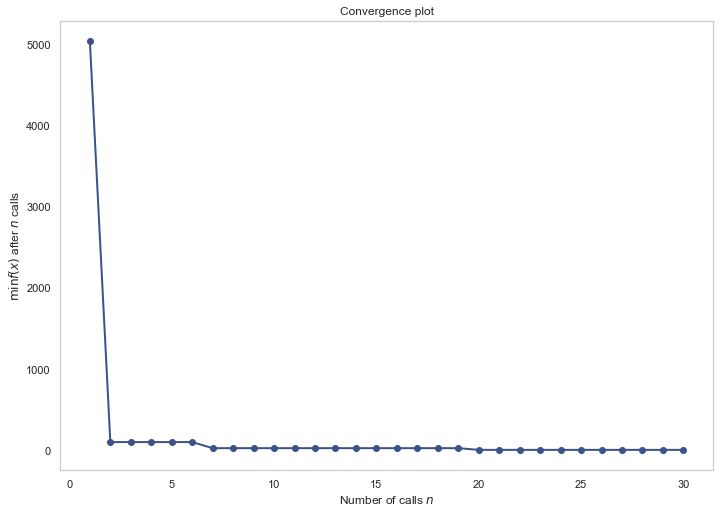

In [374]:
# re-training the final model on the full dataset to identify the selected features    
# extract coefficients based on model type

final_lr_nf, best_param_lr_nf = train_lr_baysian_nf(X_df_no75, labels_no75, 10)

In [116]:
selected_features_lr_nf = final_lr_nf.coef_[0]
selected_gene_lr_nf_final, selected_gene_lr_nf_df = identify_genes_from_coefs(selected_features_lr_nf, X_df, gene_df)
print(selected_gene_lr_nf_final)

[('ID3', -0.2173673740509193), ('UBE2Q2', -0.19148869188511258), ('HS.276860', -0.16415341220318852), ('PKIA', -0.13674584465049922), ('NMT2', -0.1045891829654626), ('CD3G', -0.034879206205886734), ('LATS2', 0.002179365017035074), ('B4GALT5', 0.04068078743432389), ('PSTPIP2', 0.04664452110716382), ('SLC2A3', 0.096096240430382), ('GSN', 0.10646723833547635), ('P2RX1', 0.15086038897006124)]


The number of selected genes is:  12


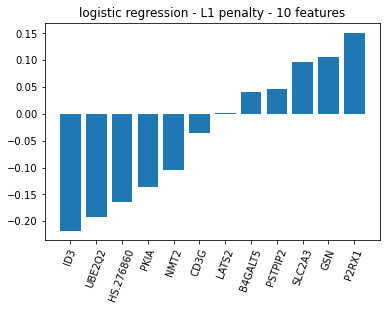

In [117]:
print('The number of selected genes is:  '+str(len(selected_gene_lr_nf_final)))
plot_genes(selected_gene_lr_nf_final, model='logistic regression - L1 penalty - 10 features')

In [127]:
selected_gene_lr_nf_df

,Probe_Id,ILMN_Gene
1198,ILMN_1656378,NMT2
10360,ILMN_1821176,HS.276860
11732,ILMN_1683817,UBE2Q2
12281,ILMN_1775708,SLC2A3
13609,ILMN_1717197,CD3G
20606,ILMN_1732296,ID3
23051,ILMN_1685824,B4GALT5
30201,ILMN_1703412,LATS2
33119,ILMN_1801043,GSN
40297,ILMN_2337974,PKIA


In [218]:
def selected_gene_zscores(selected_gene_dataframe, dataset, labels):
    
    ''' pandas datafram --> pandas datafram
    Function takes a datafrom of the selected genes, with Probe_Id and ILMN_Gene
    and the input dataset of all z-scores across all 48,000 genes, and returns a melded
    dataframe of the selected genes and their Probe_ID names, with z-scores and true class'''
    
    gene_index_probe = list(selected_gene_dataframe['Probe_Id'])
    gene_index_common = list(selected_gene_dataframe['ILMN_Gene'])
    gene_labels_dict = dict(zip(gene_index_probe, gene_index_common))
    gene_labels_dict['Class'] = 'Class'
    selected_gene_zscores_df = dataset.loc[:, gene_index_probe]
    selected_gene_zscores_df['Class'] = labels_no75
    selected_gene_zscores_df = selected_gene_zscores_df.rename(columns = gene_labels_dict)
    selected_gene_zscores_df = pd.melt(selected_gene_zscores_df, id_vars=['Class'],
                                                    value_vars=gene_index_common)
    return selected_gene_zscores_df

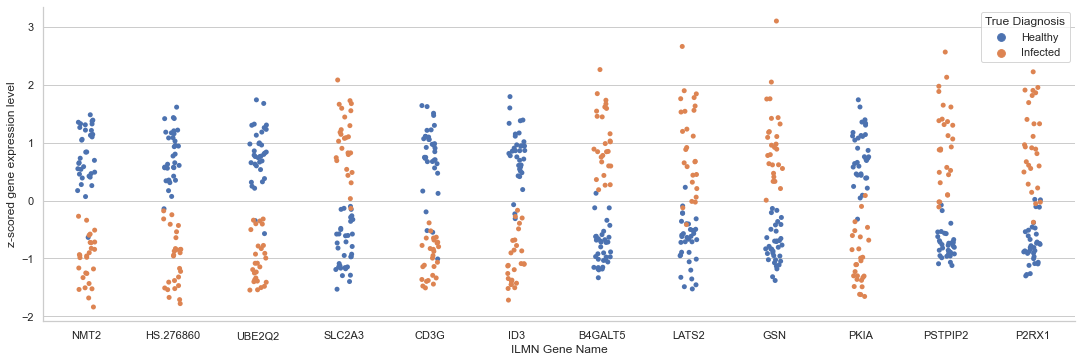

In [219]:
selected_gene_zscores_lr = selected_gene_zscores(selected_gene_lr_nf_df, X_df_no75, labels_no75)

sns.set_style("whitegrid")
lr_gene_plot = sns.catplot(data=selected_gene_zscores_lr,
                           x='variable',
                           y='value',
                           hue='Class',
                           kind='strip', 
                           height = 5,
                           aspect = 3,
                           legend=True,
                           legend_out=False,
                           )
lr_gene_plot.set(xlabel='ILMN Gene Name', ylabel='z-scored gene expression level')
lr_gene_plot._legend.set_title('True Diagnosis')
for t, l in zip(lr_gene_plot._legend.texts,("Healthy", "Infected")):
    t.set_text(l)

lr_gene_plot.savefig('lr_gene_plot.png', dpi=400)

In [368]:
# saving down results of the model:

with open('lr_results_nf.pkl', 'wb') as f:
    pickle.dump([scores_lr_nf, best_parameters_lr_nf, mis_classified_lr_nf, predictions_list_lr_nf, selected_features_list_lr_nf], f)


In [369]:
with open('lr_results_no75_30f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_30f, best_parameters_lr_no75_30f, mis_classified_lr_no75_30f, predictions_list_lr_no75_30f, selected_features_list_lr_no75_30f], f)

with open('lr_results_no75_25f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_25f, best_parameters_lr_no75_25f, mis_classified_lr_no75_25f, predictions_list_lr_no75_25f, selected_features_list_lr_no75_25f], f)

with open('lr_results_no75_20f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_20f, best_parameters_lr_no75_20f, mis_classified_lr_no75_20f, predictions_list_lr_no75_20f, selected_features_list_lr_no75_20f], f)

with open('lr_results_no75_15f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_15f, best_parameters_lr_no75_15f, mis_classified_lr_no75_15f, predictions_list_lr_no75_15f, selected_features_list_lr_no75_15f], f)

with open('lr_results_no75_10f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_10f, best_parameters_lr_no75_10f, mis_classified_lr_no75_10f, predictions_list_lr_no75_10f, selected_features_list_lr_no75_10f], f)

with open('lr_results_no75_9f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_9f, best_parameters_lr_no75_9f, mis_classified_lr_no75_9f, predictions_list_lr_no75_9f, selected_features_list_lr_no75_9f], f)

with open('lr_results_no75_8f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_8f, best_parameters_lr_no75_8f, mis_classified_lr_no75_8f, predictions_list_lr_no75_8f, selected_features_list_lr_no75_8f], f)

with open('lr_results_no75_7f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_7f, best_parameters_lr_no75_7f, mis_classified_lr_no75_7f, predictions_list_lr_no75_7f, selected_features_list_lr_no75_7f], f)

with open('lr_results_no75_6f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_6f, best_parameters_lr_no75_6f, mis_classified_lr_no75_6f, predictions_list_lr_no75_6f, selected_features_list_lr_no75_6f], f)

with open('lr_results_no75_5f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_5f, best_parameters_lr_no75_5f, mis_classified_lr_no75_5f, predictions_list_lr_no75_5f, selected_features_list_lr_no75_5f], f)

with open('lr_results_no75_4f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_4f, best_parameters_lr_no75_4f, mis_classified_lr_no75_4f, predictions_list_lr_no75_4f, selected_features_list_lr_no75_4f], f)

with open('lr_results_no75_3f.pkl', 'wb') as f:
    pickle.dump([scores_lr_no75_3f, best_parameters_lr_no75_3f, mis_classified_lr_no75_3f, predictions_list_lr_no75_3f, selected_features_list_lr_no75_3f], f)


In [177]:
with open('lr_final_model_nf.pkl', 'wb') as f:
    pickle.dump([final_lr_nf, best_param_lr_nf], f)

In [373]:
# retriving saved results:

#with open('lr_results_no75_30f.pkl', 'rb') as f:
#    test1, test2, test3, test4, test5 = pickle.load(f)


### Illustration: Precision and Recall at different thresholds

In [407]:
import seaborn as sns

In [408]:
y_predictions, y_probabilities, y_true_classes = predictions_list_lr_no75_30f[2]
y_probabilities = y_probabilities[:, 1]

In [415]:
len(y_probabilities)

20

In [422]:
y_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [421]:
8/9

0.8888888888888888

In [409]:
plot_df = pd.DataFrame(y_probabilities, columns=['Probabilities'])
plot_df['classes'] = y_true_classes

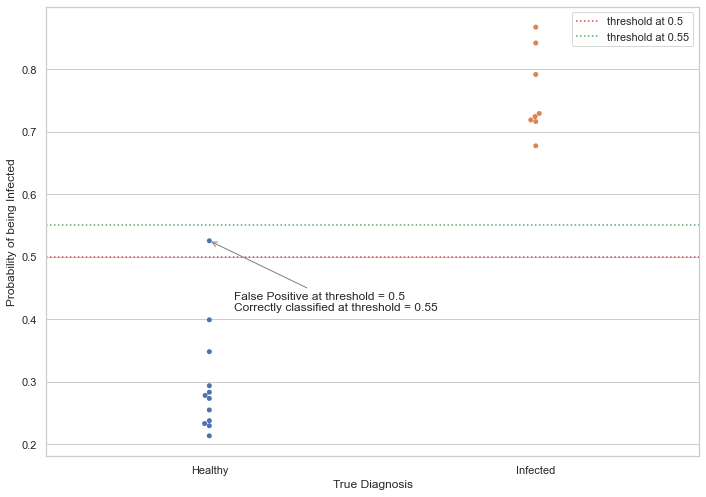

In [412]:
plot_probabs = sns.swarmplot(x="classes", y="Probabilities", data=plot_df)
# Draw a horizontal line to show the starting point
plot_probabs.axhline(y=0.5, linestyle=":", color='r', label='threshold at 0.5')
plot_probabs.axhline(y=0.55, linestyle=":", color='g', label='threshold at 0.55')
plot_probabs.legend()
plot_probabs.set(xlabel='True Diagnosis', ylabel='Probability of being Infected')
plot_probabs.set_xticklabels(['Healthy', 'Infected'])
plot_probabs.annotate(text="False Positive at threshold = 0.5\nCorrectly classified at threshold = 0.55",
                      xy=(0, 0.52554782),
                      xytext=(25, -70),
                      textcoords='offset points',
                      arrowprops=dict(arrowstyle='->', color='grey'))
fig = plot_probabs.get_figure()
fig.savefig('thresholds_example.png', dpi=400)


In [414]:
# illustration that precision / recall change based on the threshold selected

# code credit for moving thresholds - https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
# code for using Youden's J statistic to find the optimisal threshold

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_true_classes, y_probabilities)

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

def predict_class(probs, threshold):
    class_predictions = []
    for probab in probs:
        if probab >= threshold:
            class_predictions.append(1)
        else:
            class_predictions.append(0)
    return class_predictions

table = []
thesholds = [0.1, 0.3, 0.5, 0.55, 0.7]
for t in thesholds:
    scores = []
    pred_classes = predict_class(y_probabilities, t)
    acc = round(accuracy_score(y_true_classes, pred_classes),2)
    rec = round(recall_score(y_true_classes, pred_classes),2)
    presc = round(precision_score(y_true_classes, pred_classes),2)
    scores.append(acc)
    scores.append(rec)
    scores.append(presc)
    table.append(scores)
table = np.array(table)
print(table)

index = thesholds
columns = ['Accuracy', 'Recall', 'Precision']

df_threshold_illustration = pd.DataFrame(table, index=index, columns=columns)
df_threshold_illustration.index.name = 'Threshold'

with open('lr_thresholds_illustration.tex','w') as tf:
    tf.write(df_threshold_illustration.to_latex())
    
df_threshold_illustration

Best Threshold=0.677367
[[0.4  1.   0.4 ]
 [0.85 1.   0.73]
 [0.95 1.   0.89]
 [1.   1.   1.  ]
 [0.95 0.88 1.  ]]


,Accuracy,Recall,Precision
Threshold,,,
0.10,0.40,1.00,0.40
0.30,0.85,1.00,0.73
0.50,0.95,1.00,0.89
0.55,1.00,1.00,1.00
0.70,0.95,0.88,1.00


# Classifier 2: SVM

1. Initial approach, simple Linear SVM with L1 penalty to search for approx 30 features.
2. Followed by SVM + RFE as alternative approach to feature selection (wrapper method), aiming for improved model performance and similar number of features ultimately.
- Due to run time, initial feature selection using kbest feature selection and mutual information gain. Limitation.
- Further feature selection using recursive feature selection (RFE) to get down the the best performing set of features on linear svm

References:
- https://machinelearningmastery.com/rfe-feature-selection-in-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- https://machinelearningmastery.com/rfe-feature-selection-in-python/
- important point - use pipeline so that the same train and validation sets are used for both the feature
- selection and the hyperparameter tuning, avoiding data leakage from train to val. Here not
- tuning hyper parameters, but want to do all the fit transforms in a chain, to use the nested CV loop

### SVM with Baysian Optimisation of hyper parameter C, with RFE


In [492]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
#from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut
from numpy.random import uniform
import operator
from sklearn.pipeline import make_pipeline, Pipeline
import skopt
from math import log
from matplotlib import pyplot as plt
from skopt.space import Real
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_evaluations
from skopt.space import Categorical
import pickle
import warnings
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before")


In [493]:
# function to implement univariate feature selection based on kbest, to n_features

def filter_features(X_train, y_train, X_test, n_features):
    fs=SelectKBest(mutual_info_classif, k=n_features).fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    gene_list = list(zip(X_train.columns, fs.get_support()))
    new_features = []
    for gene in gene_list:
        if gene[1] == True:
            new_features.append(gene[0])
    X_train = pd.DataFrame(X_train_fs, columns=new_features, index=X_train.index)
    X_test = pd.DataFrame(X_test_fs, columns=new_features, index=X_test.index)
    return X_train, X_test

def filter_features_final(X_train, y_train, n_features):
    fs=SelectKBest(mutual_info_classif, k=n_features).fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    gene_list = list(zip(X_train.columns, fs.get_support()))
    new_features = []
    for gene in gene_list:
        if gene[1] == True:
            new_features.append(gene[0])
    X_train = pd.DataFrame(X_train_fs, columns=new_features, index=X_train.index)
    return X_train, new_features

In [495]:
# nexted cross validation function for SVM

def nested_cv_svm_baysian(df, labels, n_repeats, in_features, out_features):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    recursive feature elimination using an SVM model.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []
    selected_features_list = []                                  # added this line

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # implement univariate feature selection
        X_train, X_test = filter_features(X_train, y_train, X_test, in_features)
        
        # train and fit the model
        model, best_C = train_svm_baysian(X_train, y_train, out_features)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        selected_features = model.named_steps['feature_elim'].support_   #added this line

        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append(best_C)
        mis_classified_list.append(mis_classified)
        selected_features_list.append(selected_features)                 # added this line

    return scores_list, best_parameters_list, mis_classified_list, selected_features_list #added 4 param

# Baysian optimisation with Gaussian processes for SVM hyper parameter optimisation

def train_svm_baysian(X_train, y_train, out_features):
    
    # define hyper paramaeter search space
    hyper_p_c = Real(1e-6, 100.0, 'log-uniform', name='C')
    search_space_svm = [hyper_p_c] 

    # define the objective function to optimise
    @use_named_args(search_space_svm)
    def evaluate_model(**params):
        cv_inner = LeaveOneOut()
        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]                

            # define the pipeline
            svc = SVC(kernel="linear", probability=True)  
            svc.set_params(**params)
            rfe = RFE(estimator=svc, n_features_to_select=out_features, step=20)
            svm_pipeline = Pipeline(steps=[('rfe', rfe),
                                           ('model', svc)])
            
            svm_pipeline.fit(X_train_inner, y_train_inner)

            y_val_pred = svm_pipeline.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)

        score = accuracy_score(y_val_classes, y_val_predictions)
        return 1.0 - score
    
    # perform gp optimization, and store best hyper parameters
    result = gp_minimize(evaluate_model, search_space_svm, n_calls=20)
    plot_convergence(result)
    plt.savefig("svm_best_features_nf.jpeg")
    best_C = result.x[0]

    print('Best score: %.3f' % (1.0 - result.fun))
    print('Best C: %s' % (best_C))

    # retrain the model with selected hyper parameters
    clf = SVC(kernel="linear", C=best_C, probability=True)
    feature_elim = RFE(estimator=clf, n_features_to_select=out_features, step=20)
    model = Pipeline(steps=[('feature_elim', feature_elim),
                            ('clf', clf)])
    
    model.fit(X_train, y_train)

    return model, best_C


Best score: 0.952
Best C: 0.0080895256568617
Best score: 1.000
Best C: 3.61699892446214
Best score: 0.976
Best C: 0.028406896805552327
The results for svm with test examples:
[(0.95, 0.91, 1.0, 1.0, 1.0), (0.9, 0.8, 1.0, 1.0, 0.97), (0.95, 1.0, 0.93, 0.88, 0.99)]
[0.0080895256568617, 3.61699892446214, 0.028406896805552327]
[0.93333333 0.90333333 0.97666667 0.96       0.98666667]
[{'Inf075': 'fn'}, {'Inf_114': 'fn', 'Inf_119': 'fn'}, {'Con_202': 'fp'}]


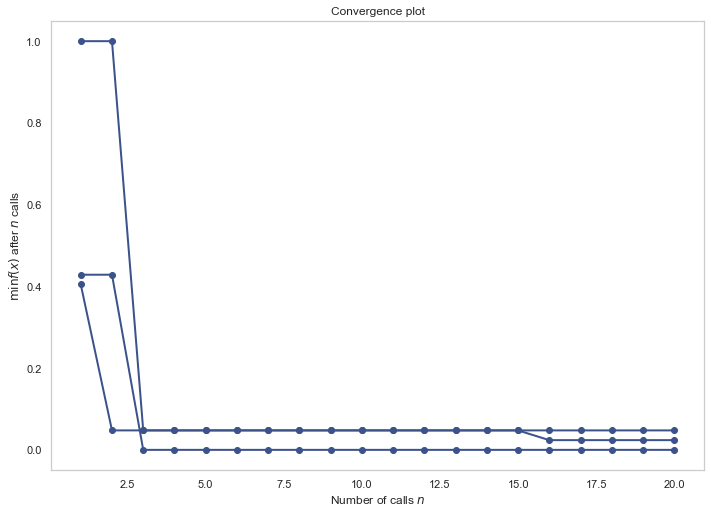

In [496]:
# train model on test set and print results
scores_svm_red_b, best_parameters_svm_red_b, mis_classified_svm_red_b, selected_features_svm_red_b = nested_cv_svm_baysian(X_df_red, labels, 1, 50, 20)

print('The results for svm with test examples:')
print(scores_svm_red_b)
print(best_parameters_svm_red_b)
print(np.mean(np.asarray(scores_svm_red_b), axis=0))
print(mis_classified_svm_red_b)


Best score: 1.000
Best C: 7.057608284501943
Best score: 1.000
Best C: 1.1787855878049414
Best score: 0.976
Best C: 0.05240665980684287
Best score: 1.000
Best C: 0.0013274551980497946
Best score: 1.000
Best C: 29.58872314375339
Best score: 1.000
Best C: 0.6033429489510737
Best score: 0.976
Best C: 0.023409304346160686
Best score: 1.000
Best C: 27.2480606051266
Best score: 1.000
Best C: 0.0868001655208731


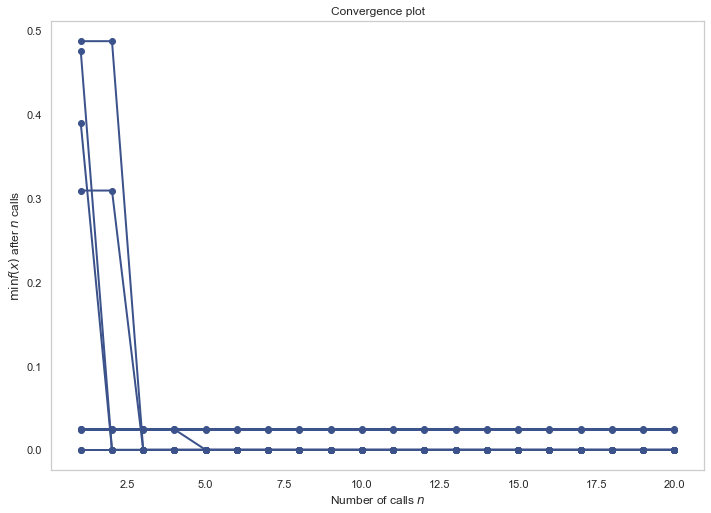

In [524]:
# train and evaluate models

# train on data set with all patients
# scores_svm_b, best_parameters_svm_b, mis_classified_svm_b = nested_cv_svm_baysian(X_df, labels, 3, 250, 20)

# train on the no75 dataset
#scores_svm_no75_b3,  best_parameters_svm_no75_b3,  mis_classified_svm_no75_b3,  selected_features_svm_no75_b3  = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 3)
#scores_svm_no75_b4,  best_parameters_svm_no75_b4,  mis_classified_svm_no75_b4,  selected_features_svm_no75_b4  = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 4)
#scores_svm_no75_b5,  best_parameters_svm_no75_b5,  mis_classified_svm_no75_b5,  selected_features_svm_no75_b5  = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 5)
#scores_svm_no75_b6,  best_parameters_svm_no75_b6,  mis_classified_svm_no75_b6,  selected_features_svm_no75_b6  = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 6)
#scores_svm_no75_b8,  best_parameters_svm_no75_b8,  mis_classified_svm_no75_b8,  selected_features_svm_no75_b8  = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 8)
#scores_svm_no75_b10, best_parameters_svm_no75_b10, mis_classified_svm_no75_b10, selected_features_svm_no75_b10 = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 10)
#scores_svm_no75_b15, best_parameters_svm_no75_b15, mis_classified_svm_no75_b15, selected_features_svm_no75_b15 = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 15)
#scores_svm_no75_b20, best_parameters_svm_no75_b20, mis_classified_svm_no75_b20, selected_features_svm_no75_b20 = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 20)
#scores_svm_no75_b25, best_parameters_svm_no75_b25, mis_classified_svm_no75_b25, selected_features_svm_no75_b25 = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 25)
scores_svm_no75_b30, best_parameters_svm_no75_b30, mis_classified_svm_no75_b30, selected_features_svm_no75_b30 = nested_cv_svm_baysian(X_df_no75, labels_no75, 3, 250, 30)


In [525]:
# saving down results of the model
import pickle

with open('svm_results_no75_30f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b30, best_parameters_svm_no75_b30, mis_classified_svm_no75_b30, selected_features_svm_no75_b30], f)

with open('svm_results_no75_25f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b25, best_parameters_svm_no75_b25, mis_classified_svm_no75_b25, selected_features_svm_no75_b25], f)

with open('svm_results_no75_20f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b20, best_parameters_svm_no75_b20, mis_classified_svm_no75_b20, selected_features_svm_no75_b20], f)

with open('svm_results_no75_15f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b15, best_parameters_svm_no75_b15, mis_classified_svm_no75_b15, selected_features_svm_no75_b15], f)

with open('svm_results_no75_10f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b10, best_parameters_svm_no75_b10, mis_classified_svm_no75_b10, selected_features_svm_no75_b10], f)

with open('svm_results_no75_8f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b8, best_parameters_svm_no75_b8, mis_classified_svm_no75_b8, selected_features_svm_no75_b8], f)

with open('svm_results_no75_6f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b6, best_parameters_svm_no75_b6, mis_classified_svm_no75_b6, selected_features_svm_no75_b6], f)

with open('svm_results_no75_5f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b5, best_parameters_svm_no75_b5, mis_classified_svm_no75_b5, selected_features_svm_no75_b5], f)

with open('svm_results_no75_4f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b4, best_parameters_svm_no75_b4, mis_classified_svm_no75_b4, selected_features_svm_no75_b4], f)

with open('svm_results_no75_3f.pkl', 'wb') as f:
    pickle.dump([scores_svm_no75_b3, best_parameters_svm_no75_b3, mis_classified_svm_no75_b3, selected_features_svm_no75_b3], f)


In [180]:
#with open('svm_results_no75_10f.pkl', 'rb') as f:
#    scores_svm_no75_b10, best_parameters_svm_no75_b10, mis_classified_svm_no75_b10, selected_features_svm_no75_b10 = pickle.load(f)

In [194]:
# function to convert svm results to dataframe:

def svm_results_df(scores, parameters, misclassified):
    p_list = np.array(parameters)
    p_list = np.around(p_list, decimals=2)
    p_list = np.append(p_list, ['n/a'], axis=0)
    mean_scores = np.mean(np.asarray(scores), axis=0)
    array = np.array(scores)
    array = np.vstack((array, mean_scores))
    array = pd.DataFrame(array, index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 'Total'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])
    array = array.round(2)
    array.insert(0, 'Best C', p_list)

    # create columns for false positives and false negatives
    fp_column = []
    fn_column = []
    for i in misclassified:
        fps = []
        fns = []
        for key, val in i.items():
            if val == 'fp':
                fps.append(key)
            if val == 'fn':
                fns.append(key)
        fp_column.append(fps)
        fn_column.append(fns)
    fp_column.append('n/a')
    fn_column.append('n/a')
    array.insert(6, 'False Positives', fp_column)
    array.insert(7, 'False Negatives', fn_column) 
    
    return array

In [526]:
# results with no patient 75
svm_df_b3  = svm_results_df(scores_svm_no75_b3,  best_parameters_svm_no75_b3,  mis_classified_svm_no75_b3)
svm_df_b4  = svm_results_df(scores_svm_no75_b4,  best_parameters_svm_no75_b4,  mis_classified_svm_no75_b4)
svm_df_b5  = svm_results_df(scores_svm_no75_b5,  best_parameters_svm_no75_b5,  mis_classified_svm_no75_b5)
svm_df_b6  = svm_results_df(scores_svm_no75_b6,  best_parameters_svm_no75_b6,  mis_classified_svm_no75_b6)
svm_df_b8  = svm_results_df(scores_svm_no75_b8,  best_parameters_svm_no75_b8,  mis_classified_svm_no75_b8)
svm_df_b10 = svm_results_df(scores_svm_no75_b10, best_parameters_svm_no75_b10, mis_classified_svm_no75_b10)
svm_df_b15 = svm_results_df(scores_svm_no75_b15, best_parameters_svm_no75_b15, mis_classified_svm_no75_b15)
svm_df_b20 = svm_results_df(scores_svm_no75_b20, best_parameters_svm_no75_b20, mis_classified_svm_no75_b20)
svm_df_b25 = svm_results_df(scores_svm_no75_b25, best_parameters_svm_no75_b25, mis_classified_svm_no75_b25)
svm_df_b30 = svm_results_df(scores_svm_no75_b30, best_parameters_svm_no75_b30, mis_classified_svm_no75_b30)


In [533]:
# putting results into a dataframe
svm_results_frames = [svm_df_b30,svm_df_b25,svm_df_b20,svm_df_b15,svm_df_b10,svm_df_b8,svm_df_b6,svm_df_b5,svm_df_b4,svm_df_b3]
svm_avg_auc= []
for df in svm_results_frames:
    avg_auc = df['AUC'].values[-1]
    svm_avg_auc.append(avg_auc)
svm_perf_features = pd.DataFrame(data=svm_avg_auc, columns=['AUC'])
svm_perf_features.insert(0, 'Features', [30,25,20,15,10,8,6,5,4,3])
svm_perf_features

,Features,AUC
0,30,1.00
1,25,0.99
2,20,0.99
3,15,1.00
4,10,0.99
5,8,0.99
6,6,1.00
7,5,0.99
8,4,0.99
9,3,0.99


In [527]:
# display dataframe

svm_df_b30

,Best C,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,7.06,0.95,0.91,1.00,1.00,1.00,[],[Inf_149]
2,1.18,0.90,1.00,0.83,0.82,1.00,"[Con_040, Con_165a]",[]
3,0.05,1.00,1.00,1.00,1.00,1.00,[],[]
4,0.0,1.00,1.00,1.00,1.00,1.00,[],[]
5,29.59,1.00,1.00,1.00,1.00,1.00,[],[]
6,0.6,0.90,0.86,1.00,1.00,1.00,[],"[Inf_149, Inf_198]"
7,0.02,0.95,1.00,0.91,0.91,1.00,[Con_165a],[]
8,27.25,0.95,0.90,1.00,1.00,1.00,[],[Inf_114]
9,0.09,0.95,0.86,1.00,1.00,0.99,[],[Inf_149]
Total,n/a,0.96,0.95,0.97,0.97,1.00,n/a,n/a


In [504]:
svm_df_b10

,Best C,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,0.03,1.00,1.00,1.00,1.00,1.00,[],[]
2,43.43,0.90,0.90,0.91,0.90,0.99,[Con_165a],[Inf_149]
3,0.01,1.00,1.00,1.00,1.00,1.00,[],[]
4,0.0,0.90,0.88,0.92,0.88,0.99,[Con_165a],[Inf_149]
5,0.02,1.00,1.00,1.00,1.00,1.00,[],[]
6,0.01,0.95,0.89,1.00,1.00,1.00,[],[Inf_114]
7,31.27,1.00,1.00,1.00,1.00,1.00,[],[]
8,25.65,0.86,0.70,1.00,1.00,1.00,[],"[Inf_114, Inf_116, Inf_132a]"
9,0.09,1.00,1.00,1.00,1.00,1.00,[],[]
Total,n/a,0.96,0.93,0.98,0.98,1.00,n/a,n/a


In [479]:
# produce the LaTex code:

with open('svm_results_table_nf_no75_b30.tex','w') as tf:
    tf.write(svm_results_df_nf_no75_b30.to_latex())

### Feature stability evaluation

[('HS.561046', 3), ('PACS2', 2), ('CCDC71', 2), ('SIX6', 2), ('HS.574219', 2), ('HS.561095', 2), ('HS.559981', 2), ('GPR61', 2), ('UBE2B', 2), ('FLJ40125', 2), ('OTP', 2), ('ERCC8', 2), ('PRR15', 2), ('MYL7', 2), ('HS.543619', 2), ('C22ORF28', 2), ('LOC649978', 1), ('LOC648894', 1), ('TMEM54', 1), ('EFR3A', 1), ('HS.560007', 1), ('MYOT', 1), ('DDA1', 1), ('GALNT12', 1), ('LOC651763', 1), ('C17ORF53', 1), ('NUBP2', 1), ('LOC644444', 1), ('STEAP1', 1), ('ICHTHYIN', 1), ('HS.551655', 1), ('SEPW1', 1), ('SNX1', 1), ('HS.540469', 1), ('CCDC25', 1), ('MAPK12', 1), ('FLJ22222', 1), ('CXXC5', 1), ('HS.344872', 1), ('HS.538610', 1), ('FRAT1', 1), ('HS.543170', 1), ('HS.155607', 1), ('HS.538076', 1), ('ZNF473', 1), ('SPRED2', 1), ('KRTAP5-7', 1), ('LOC643920', 1), ('LOC643665', 1), ('KCNG1', 1), ('KRT25', 1), ('DHPS', 1), ('PCDHB10', 1), ('LOC649101', 1), ('ABCA12', 1), ('CTSC', 1), ('HS.540557', 1), ('RBM19', 1), ('LOC653832', 1), ('LSR', 1), ('HS.174508', 1), ('LOC642111', 1), ('WFIKKN1', 1), 

<AxesSubplot:>

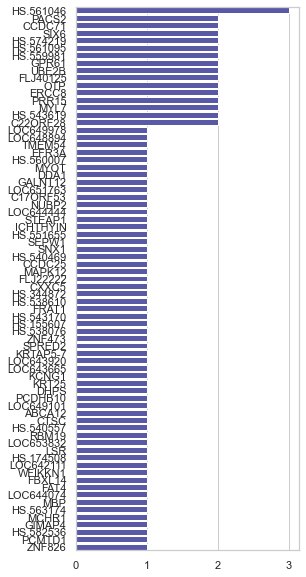

In [535]:
test_gene_feature_list = selected_features_svm_no75_b10

gene_frequency={}
for feature_list in test_gene_feature_list:
    g_list, g_df = identify_genes_from_coefs(feature_list, X_df, gene_df)
    common_names = g_df['ILMN_Gene']
    for gene in common_names:
        if gene not in gene_frequency: gene_frequency[gene]=1
        else: gene_frequency[gene]+=1

sorted_list = sorted(gene_frequency.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_list)

# print them with frequencies
#i=0
x = []
y = []
for gene, frequency in sorted_list:
    #i+=1
    #print (str(i)+". "+gene+" - "+str(frequency))
    x.append(gene)
    y.append(frequency)

hist_data = {'Gene': pd.Series(data=x),
         'Frequency': pd.Series(data=y)}

hist_df = pd.DataFrame(data=hist_data)
hist_df

sns.set_palette("muted")
f, ax = plt.subplots(figsize=(4, 10))
sns.set_theme(style="whitegrid")
sns.barplot(y='Gene', x='Frequency', data=hist_data, orient='h', color="blue", saturation=0.3)



In [380]:
from scipy.spatial import distance

# ref: https://www.scss.tcd.ie/publications/tech-reports/reports.02/TCD-CS-2002-28.pdf
masks_array = []
for feature_list in selected_features_list_lr_no75_10f:
    mask = feature_list > 0
    masks_array.append(mask)
    
print(masks_array)

def normalised_total_hemming(masks_array):
    W = len(masks_array)
    P = (W*(W-1))/2
    N = len(masks_array[0])
    H = np.sum([distance.hamming(masks_array[i], masks_array[j]) for i in range(0, W) for j in range(i+1, W)])
    H_bar = H/P
    H_hat = H_bar/N
    return H_hat

normalised_total_hemming(masks_array)

[array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False])]


6.8113799271091986e-09

### SVM: Final Model Retraining

Best score: 0.984
Best C: 0.007088686648887237


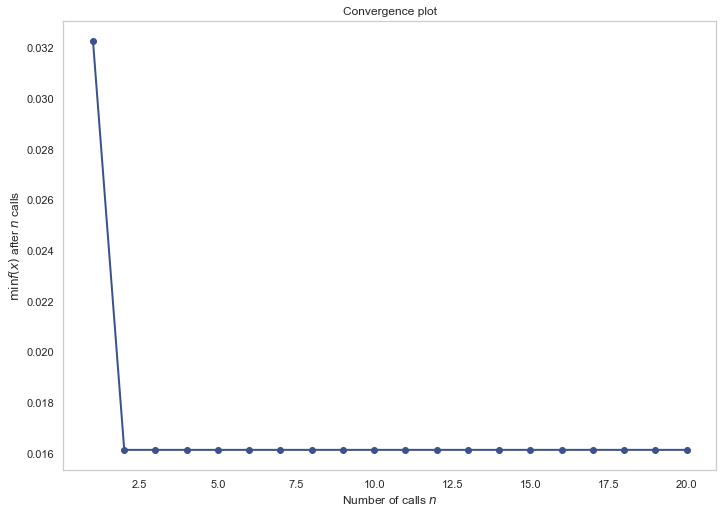

In [195]:
# re-training the final model on the full dataset to identify the selected features    

# filter the features of the entire dataset
X_df_filtered_svm_b, filtered_gene_codes_svm_b = filter_features_final(X_df_no75, labels_no75, 250)

# extract coefficients based on model type
final_svm_b, best_C_b = train_svm_baysian(X_df_filtered_svm_b, labels_no75, 5)


In [196]:
with open('svm_b_final_model.pkl', 'wb') as f:
    pickle.dump([X_df_filtered_svm_b, filtered_gene_codes_svm_b, final_svm_b, best_C_b], f)

In [536]:
with open('svm_b_final_model.pkl', 'rb') as f:
    X_df_filtered_svm_b, filtered_gene_codes_svm_b, final_svm_b, best_C_b = pickle.load(f)

In [197]:
# extract coefficients following RFE

selected_features_svm_b = final_svm_b.named_steps['feature_elim'].support_

selected_gene_list_svm_b = list(zip(filtered_gene_codes_svm_b, selected_features_svm_b))

selected_gene_codes_svm_b = []
for gene in selected_gene_list_svm_b:
    if gene[1] == True:
        selected_gene_codes_svm_b.append(gene[0])

# identify common gene codes
selected_gene_svm_b_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes_svm_b)].iloc[:, np.r_[14, 5]]
selected_gene_codes_common_svm_b = list(selected_gene_svm_b_df.iloc[:,1])

# coefficients of the selected features
selected_gene_coefficients_svm_b = final_svm_b.named_steps['clf'].coef_[0]
selected_gene_svm_b_df['Coefs'] = selected_gene_coefficients_svm_b
print(selected_gene_svm_b_df)
selected_gene_svm_b_final = list(zip(selected_gene_codes_common_svm_b, selected_gene_coefficients_svm_b))
selected_gene_svm_b_final = sorted(selected_gene_svm_b_final, key = lambda x: x[1])

print(selected_gene_svm_b_final)

           Probe_Id ILMN_Gene     Coefs
11732  ILMN_1683817    UBE2Q2 -0.205333
20606  ILMN_1732296       ID3 -0.216677
30201  ILMN_1703412     LATS2  0.198716
33119  ILMN_1801043       GSN  0.191228
47654  ILMN_1758529     P2RX1  0.202127
[('ID3', -0.2166774027257026), ('UBE2Q2', -0.20533275309754453), ('GSN', 0.19122820851689465), ('LATS2', 0.19871581481708128), ('P2RX1', 0.2021269364037488)]


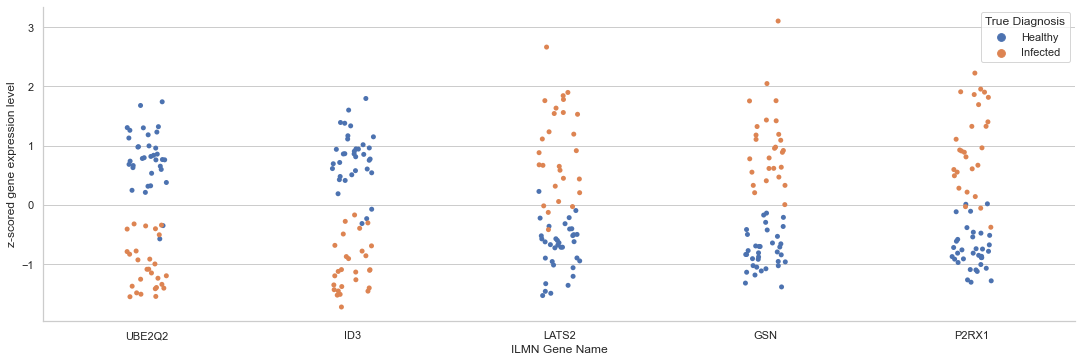

In [221]:
selected_gene_zscores_svm = selected_gene_zscores(selected_gene_svm_b_df, X_df_no75, labels_no75)

sns.set_style("whitegrid")
svm_gene_plot = sns.catplot(data=selected_gene_zscores_svm,
                           x='variable',
                           y='value',
                           hue='Class',
                           kind='strip', 
                           height = 5,
                           aspect = 3,
                           legend=True,
                           legend_out=False,
                           )
svm_gene_plot.set(xlabel='ILMN Gene Name', ylabel='z-scored gene expression level')
svm_gene_plot._legend.set_title('True Diagnosis')
for t, l in zip(svm_gene_plot._legend.texts,("Healthy", "Infected")):
    t.set_text(l)

svm_gene_plot.savefig('svm_gene_plot.png', dpi=400)

In [260]:
#plot_genes(selected_gene_svm_b_final, model='svm_baysian_optimisation')

### Classifier 3: Random Forest

- Random Forest / Tree based models have intrinsic feature selection built in (read up)
- ref: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- ref: https://www.researchgate.net/profile/Shuzlina-Rahman/publication/322920304_Feature_selection_methods_Case_of_filter_and_wrapper_approaches_for_maximising_classification_accuracy/links/5eb17fa545851592d6b9b50c/Feature-selection-methods-Case-of-filter-and-wrapper-approaches-for-maximising-classification-accuracy.pdf?origin=publication_detail
- Improved by using full feature set and setting max_features for each tree - randomised search over number of estimators and the max features
- Ran model through the nested CV and averaged the results
- Extracted the feature importances from the resulting model, for comparison with other models

### RF - using grid search over hyper parameters, and OOB scoring for validation

In [199]:
# Grid search - implemented manually for Random Forest hyper parameter optimisation

from sklearn.model_selection import ParameterGrid, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

def nested_cv_rf_oob(df, labels, n_repeats, n_features):
    '''dataframe, labels, integer -> lists of scores, best hyper parameters, selected features, mis-classified points
    
    This function implements a nested cross validation. The outer loop is a repeated k fold, that creates multiple
    alternative train / test splits. The inner loop performs hyper parameter optimisation and feature selection using
    using by scoring out of bag examples.
    '''
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []
    num_features_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # train and fit the model
        model, best_n_estimators, best_max_features, num_features = train_rf_oob(X_train, y_train, n_features)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)

        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append((best_n_estimators, best_max_features))
        mis_classified_list.append(mis_classified)
        num_features_list.append(num_features)

    return scores_list, best_parameters_list, mis_classified_list, num_features_list


def train_rf_oob(X_train, y_train, n_features):

    # define pipeline and perform search
    n_estimators = [int(x) for x in [500, 1000]]  # n_estimators large since low sample size
    max_features = [100, 200, 500]
    param_grid = {'n_estimators': n_estimators,
                   'max_features': max_features
                   }
    
    cv_res= []

    for param in ParameterGrid(param_grid):

        # fit model      
        rf_clf_select = RandomForestClassifier()
        rf_clf_select.set_params(**param)
        rf_clf = RandomForestClassifier(n_estimators=1000, max_features=None, oob_score = True)
        rf_select = SelectFromModel(rf_clf_select, max_features=n_features, threshold=-np.inf)
        pipe = Pipeline(steps=[('select', rf_select),
                               ('clf', rf_clf)])
        
        pipe.fit(X_train, y_train)

        score = pipe.named_steps['clf'].oob_score_
        print('Parameters:'+str(param)+'  Score:'+str(score))
        cv_res.append([param['n_estimators'], param['max_features'], score])

    cv_res = np.asarray(cv_res)    
    best_n_estimators = int(cv_res[np.argmax(cv_res[:,2])][0])
    best_max_features = int(cv_res[np.argmax(cv_res[:,2])][1])

    # retrain the model with optimum hyper parameters
    rf_clf_select = RandomForestClassifier(n_estimators=best_n_estimators, max_features=best_max_features) 
    rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_features=None, oob_score = True)
    rf_select = SelectFromModel(rf_clf_select, max_features=n_features, threshold=-np.inf)
    model = Pipeline(steps=[('select', rf_select),
                            ('clf', rf_clf)])
    model.fit(X_train, y_train)
    num_features = len(model.named_steps['select'].get_support(indices=True))
    
    print('Best no. estimators:  '+str(best_n_estimators)+
          ',    Best max features:  '+str(best_max_features)+
          ',    Number of features:  '+str(n_features))

    return model, best_n_estimators, best_max_features, num_features

In [457]:
# run model on test dataset and print results
# scores_rf_oob_test, best_parameters_rf_oob_test, mis_classified_rf_oob_test, features_rf_oob_test = nested_cv_rf_oob(X_df_red, labels, 1, 20)

#print('The results for rf_oob with the test dataset:')
#print(scores_rf_oob_test)
#print(best_parameters_rf_oob_test)
#print(np.mean(np.asarray(scores_rf_oob_test), axis=0))
#print(mis_classified_rf_oob_test)
#print(features_rf_oob_test)

In [456]:
#scores_rf_oob, best_parameters_rf_oob, mis_classified_rf_oob = nested_cv_rf_oob(X_df, labels, 3)

# train the model with the full dataset, for 20 featurs
scores_rf_no75_oob5,  best_parameters_rf_no75_oob5,  mis_classified_rf_no75_oob5,  features_rf_no75_oob5  = nested_cv_rf_oob(X_df_no75, labels_no75, 3, 5)
scores_rf_no75_oob10, best_parameters_rf_no75_oob10, mis_classified_rf_no75_oob10, features_rf_no75_oob10 = nested_cv_rf_oob(X_df_no75, labels_no75, 3, 10)
scores_rf_no75_oob15, best_parameters_rf_no75_oob15, mis_classified_rf_no75_oob15, features_rf_no75_oob15 = nested_cv_rf_oob(X_df_no75, labels_no75, 3, 15)
scores_rf_no75_oob20, best_parameters_rf_no75_oob20, mis_classified_rf_no75_oob20, features_rf_no75_oob20 = nested_cv_rf_oob(X_df_no75, labels_no75, 3, 20)
scores_rf_no75_oob30, best_parameters_rf_no75_oob30, mis_classified_rf_no75_oob30, features_rf_no75_oob30 = nested_cv_rf_oob(X_df_no75, labels_no75, 3, 30)


Parameters:{'max_features': 100, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:0.975609756097561
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  100,    Number of features:  5
Parameters:{'max_features': 100, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:0.9512195121951219
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  100,    Number of features:  5
Parameters:{'max_featur

Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  200,    Number of features:  10
Parameters:{'max_features': 100, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:0.9761904761904762
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:0.9761904761904762
Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  100,    Number of features:  10
Parameters:{'max_features': 100, 'n_estimators': 500}  Score:0.975609756097561
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:1.0
Parame

Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  100,    Number of features:  20
Parameters:{'max_features': 100, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  100,    Number of features:  20
Parameters:{'max_features': 100, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 5

In [468]:
# print results for full dataset
#print('The results for rf_oob without patient 75:')
#print(scores_rf_no75_oob)
#print(best_parameters_rf_no75_oob)
#print(np.mean(np.asarray(scores_rf_no75_oob), axis=0))
#print(mis_classified_rf_no75_oob)
#print(features_rf_no75_oob)

In [200]:
# function to convert random forest results to dataframe:

def rf_results_df(scores, parameters, misclassified):
    mean_scores = np.mean(np.asarray(scores), axis=0)
    array = np.array(scores)
    array = np.vstack((array, mean_scores))
    array = pd.DataFrame(array, index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 'Total'], columns = ['Accuracy', 'Recall', 'Specificity', 'Precision', 'AUC'])
    array = array.round(2)
    
    # create columns for parameters
    n_est = []
    max_feat = []
    for p in parameters:
        n_est.append(p[0])
        max_feat.append(p[1])
    n_est.append('n/a')
    max_feat.append('n/a')
    array.insert(0, 'Max Features', max_feat) 
    array.insert(0, '# Estimators', n_est)

    
    # create columns for false positives and false negatives
    fp_column = []
    fn_column = []
    for i in misclassified:
        fps = []
        fns = []
        for key, val in i.items():
            if val == 'fp':
                fps.append(key)
            if val == 'fn':
                fns.append(key)
        fp_column.append(fps)
        fn_column.append(fns)
    fp_column.append('n/a')
    fn_column.append('n/a')
    array.insert(7, 'False Positives', fp_column)
    array.insert(8, 'False Negatives', fn_column) 
    
    return array

In [458]:
# restults dataframes
rf_results_df_no75_5 = rf_results_df(scores_rf_no75_oob5, best_parameters_rf_no75_oob5, mis_classified_rf_no75_oob5)
rf_results_df_no75_10 = rf_results_df(scores_rf_no75_oob10, best_parameters_rf_no75_oob10, mis_classified_rf_no75_oob10)
rf_results_df_no75_15 = rf_results_df(scores_rf_no75_oob15, best_parameters_rf_no75_oob15, mis_classified_rf_no75_oob15)
rf_results_df_no75_20 = rf_results_df(scores_rf_no75_oob20, best_parameters_rf_no75_oob20, mis_classified_rf_no75_oob20)
rf_results_df_no75_30 = rf_results_df(scores_rf_no75_oob30, best_parameters_rf_no75_oob30, mis_classified_rf_no75_oob30)

In [460]:
rf_results_df_no75_5

,# Estimators,Max Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,500,100,0.86,1.00,0.77,0.73,0.96,"[Con_087a, Con_165a, Con_181a]",[]
2,500,100,0.95,0.90,1.00,1.00,1.00,[],[Inf_132a]
3,500,200,0.90,0.78,1.00,1.00,0.99,[],"[Inf_116, Inf_149]"
4,500,100,0.90,1.00,0.86,0.78,1.00,"[Con_069, Con_096a]",[]
5,1000,100,0.95,0.92,1.00,1.00,1.00,[],[Inf_116]
6,500,100,0.95,1.00,0.92,0.88,0.97,[Con_165a],[]
7,1000,200,1.00,1.00,1.00,1.00,1.00,[],[]
8,500,100,0.86,0.78,0.92,0.88,0.98,[Con_079],"[Inf_132a, Inf_149]"
9,1000,200,1.00,1.00,1.00,1.00,1.00,[],[]
Total,n/a,n/a,0.93,0.93,0.94,0.92,0.99,n/a,n/a


In [462]:
rf_results_df_no75_10

,# Estimators,Max Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,500,200,1.00,1.00,1.00,1.00,1.00,[],[]
2,500,100,0.95,0.90,1.00,1.00,0.99,[],[Inf_149]
3,500,100,0.95,1.00,0.93,0.83,1.00,[Con_165a],[]
4,500,100,0.95,0.91,1.00,1.00,1.00,[],[Inf_149]
5,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
6,500,100,0.85,1.00,0.77,0.70,1.00,"[Con_079, Con_165a, Con_206]",[]
7,500,100,0.95,0.90,1.00,1.00,0.98,[],[Inf_149]
8,500,200,1.00,1.00,1.00,1.00,1.00,[],[]
9,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
Total,n/a,n/a,0.96,0.97,0.97,0.95,1.00,n/a,n/a


In [463]:
rf_results_df_no75_15

,# Estimators,Max Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,1000,100,1.00,1.00,1.00,1.00,1.00,[],[]
2,500,100,0.95,0.92,1.00,1.00,0.99,[],[Inf_149]
3,500,100,0.95,0.86,1.00,1.00,0.99,[],[Inf_114]
4,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
5,500,100,0.90,0.80,1.00,1.00,0.98,[],"[Inf_114, Inf_149]"
6,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
7,1000,100,0.95,1.00,0.90,0.92,0.98,[Con_165a],[]
8,500,100,0.95,0.88,1.00,1.00,1.00,[],[Inf_149]
9,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
Total,n/a,n/a,0.97,0.94,0.99,0.99,0.99,n/a,n/a


In [464]:
rf_results_df_no75_20

,# Estimators,Max Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,500,100,0.95,0.83,1.00,1.00,1.00,[],[Inf_149]
2,500,100,0.95,1.00,0.89,0.92,1.00,[Con_165a],[]
3,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
4,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
5,500,200,1.00,1.00,1.00,1.00,1.00,[],[]
6,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
7,500,100,0.95,0.91,1.00,1.00,0.98,[],[Inf_149]
8,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
9,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
Total,n/a,n/a,0.98,0.97,0.99,0.99,1.00,n/a,n/a


In [465]:
rf_results_df_no75_30

,# Estimators,Max Features,Accuracy,Recall,Specificity,Precision,AUC,False Positives,False Negatives
1,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
2,500,100,0.95,0.88,1.00,1.00,0.99,[],[Inf_149]
3,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
4,500,100,0.90,0.92,0.89,0.92,0.99,[Con_165a],[Inf_149]
5,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
6,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
7,500,100,0.95,1.00,0.92,0.90,1.00,[Con_165a],[]
8,500,100,1.00,1.00,1.00,1.00,1.00,[],[]
9,500,100,0.85,0.62,1.00,1.00,1.00,[],"[Inf_114, Inf_116, Inf_149]"
Total,n/a,n/a,0.96,0.94,0.98,0.98,1.00,n/a,n/a


In [477]:
# produce the LaTex code:

with open('rf_results_table_no75_30.tex','w') as tf:
    tf.write(rf_results_df_no75_30.to_latex())

In [202]:
# retraining on the full dataset with the oob scored model using 5 features only - since performance was good

final_rf_oob, best_n_estimators_oob, best_max_features_oob, num_features_oob = train_rf_oob(X_df_no75, labels_no75, 5)

Parameters:{'max_features': 100, 'n_estimators': 500}  Score:0.9838709677419355
Parameters:{'max_features': 100, 'n_estimators': 1000}  Score:0.9838709677419355
Parameters:{'max_features': 200, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 200, 'n_estimators': 1000}  Score:0.967741935483871
Parameters:{'max_features': 500, 'n_estimators': 500}  Score:1.0
Parameters:{'max_features': 500, 'n_estimators': 1000}  Score:1.0
Best no. estimators:  500,    Best max features:  200,    Number of features:  5


In [230]:
def select_genes_fi_pipeline(model, dataset, gene_df):
    
    # mask of features selected by SelectFromModel
    feature_mask = model.named_steps['select'].get_support()
    
    # feature importances of the selected genes
    importances = model.named_steps['clf'].feature_importances_
    
    # extract the selected genes based on the mask
    selected_gene_list = list(zip(dataset.columns, feature_mask))
    selected_gene_codes = []
    selected_gene_coefficients = []
    for gene in selected_gene_list:
        if gene[1] == True:
            selected_gene_codes.append(gene[0])

    # identify common gene codes
    selected_gene_df = gene_df[gene_df['Probe_Id'].isin(selected_gene_codes)].iloc[:, np.r_[14, 5]]
    selected_gene_codes_common = list(selected_gene_df.iloc[:,1])

    # combining gene codes with feature importances
    selected_gene_df['FI'] = importances
    
    # zip features importances with common names
    selected_gene_final = list(zip(selected_gene_codes_common, importances))
    selected_gene_final = sorted(selected_gene_final, key = lambda x: x[1])
    
    return selected_gene_final, selected_gene_df

In [229]:
# generate dataframe of selected genes and importances

selected_gene_rf_final_oob, selected_gene_rf_df = select_genes_fi_pipeline(final_rf_oob, X_df_no75, gene_df)
print('The number of selected genes is:  '+str(len(selected_gene_rf_final_oob)))
selected_gene_rf_df

The number of selected genes is:  5


,Probe_Id,ILMN_Gene,FI
13839,ILMN_2082209,C20ORF100,0.692
16466,ILMN_1692545,LOC646849,0.038
36932,ILMN_1767960,NSUN7,0.190
42653,ILMN_1755843,SLC26A8,0.064
46238,ILMN_1800602,GCA,0.016


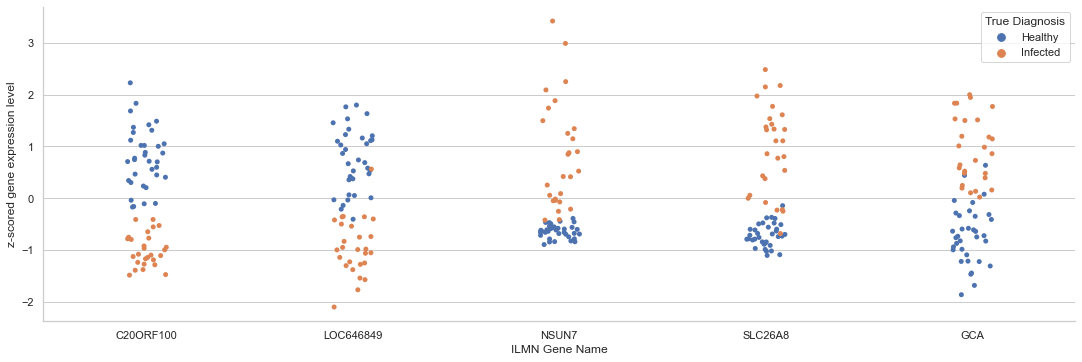

In [225]:
# get the z-scores for selected genes and visualise

selected_gene_zscores_rf = selected_gene_zscores(selected_gene_rf_df, X_df_no75, labels_no75)

sns.set_style("whitegrid")
rf_gene_plot = sns.catplot(data=selected_gene_zscores_rf,
                           x='variable',
                           y='value',
                           hue='Class',
                           kind='strip', 
                           height = 5,
                           aspect = 3,
                           legend=True,
                           legend_out=False,
                           )
rf_gene_plot.set(xlabel='ILMN Gene Name', ylabel='z-scored gene expression level')
rf_gene_plot._legend.set_title('True Diagnosis')
for t, l in zip(rf_gene_plot._legend.texts,("Healthy", "Infected")):
    t.set_text(l)

rf_gene_plot.savefig('rf_gene_plot.png', dpi=400)

In [259]:
# plot selected genes with their feature importances
# plot_genes(selected_gene_rf_final_oob, model='random forest - oob')

In [484]:
# save down results with pickle

# saving down results of the model
import pickle

with open('rf_results_no75_oob.pkl', 'wb') as f:
    pickle.dump([scores_rf_no75_oob5,  best_parameters_rf_no75_oob5,  mis_classified_rf_no75_oob5,  features_rf_no75_oob5,
                 scores_rf_no75_oob10, best_parameters_rf_no75_oob10, mis_classified_rf_no75_oob10, features_rf_no75_oob10,
                 scores_rf_no75_oob15, best_parameters_rf_no75_oob15, mis_classified_rf_no75_oob15, features_rf_no75_oob15,
                 scores_rf_no75_oob20, best_parameters_rf_no75_oob20, mis_classified_rf_no75_oob20, features_rf_no75_oob20,
                 scores_rf_no75_oob30, best_parameters_rf_no75_oob30, mis_classified_rf_no75_oob30, features_rf_no75_oob30], f)


In [206]:
with open('rf_final_model_no75_oob.pkl', 'wb') as f:
    pickle.dump([final_rf_oob, best_n_estimators_oob, best_max_features_oob, num_features_oob], f)

### Gene Identification Summary

Using most important features output to identify the genes used by the classifiers

In [351]:
def unzip(features):
    genes = [ i for i, j in features]
    return genes

lr_genes = unzip(selected_gene_lr_nf_final)
svm_genes = unzip(selected_gene_svm_b_final)
rf_genes_all = unzip(selected_gene_rf_final_oob[-31:-1])

intersection_list = []
intersection_list.extend(list(set(lr_genes).intersection(svm_genes)))
intersection_list.extend(list(set(lr_genes).intersection(rf_genes_all)))
intersection_list.extend(list(set(svm_genes).intersection(rf_genes_all)))

intersection_list

['B4GALT5',
 'ATP6V0E2',
 'GSN',
 'PDE9A',
 'FCGBP',
 'NBEAL2',
 'C20ORF100',
 'NMT2',
 'UBE2Q2',
 'ID3',
 'C20ORF100',
 'HS.276860',
 'ATP6V0E2',
 'NBEAL2',
 'ATP6V0E2',
 'C20ORF100',
 'LRRN3',
 'NBEAL2']

### Classifier 4: XGBoost

- Using the XGBoost library rather than sklearn, given more features available
- code credit: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
- code credit: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- Feature elimination with XGBoost- https://github.com/dhamvi01/Xgboost-Feature-Elimination/blob/master/Xgb-RFE.py

In [975]:
import xgboost as xgb

In [978]:
# nested cross validation function, customised to xgb

def nested_cv_xgb(df, labels, n_repeats):
    
    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        # train model
        model, best_max_depth, best_learning_rate, best_colsample_bytree = train_xgb(X_train, y_train)
        
        # model predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_probab = model.predict_proba(X_test)

        # evaluate the model
        scores = score_model(y_pred, y_pred_probab, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)
        
        # add scores to lists
        scores_list.append(scores)
        best_parameters_list.append((best_max_depth,best_learning_rate, best_colsample_bytree, best_f))
        mis_classified_list.append(mis_classified)

    return scores_list, best_parameters_list, mis_classified_list


# function to train xgb model

def train_xgb(X_train, y_train):
      
    param_grid = {"max_depth": [3, 5],
                  "learning_rate": [0.3],
                  "colsample_bytree": [0.01, 0.1, 1]}
    cv_inner = loocv
    cv_res= []

    for param in ParameterGrid(param_grid):

        y_val_classes = []
        y_val_predictions = []
        for train_index, val_index in cv_inner.split(X_train):

            X_train_inner, X_val = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
            y_train_inner, y_val = y_train[train_index], y_train[val_index]                

            # define the rfe proceedure
            xgb_clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss')       
            xgb_clf.fit(X_train_inner, y_train_inner)

            y_val_pred = xgb_clf.predict(X_val)
            y_val_classes.append(y_val)
            y_val_predictions.append(y_val_pred)

        score = accuracy_score(y_val_classes, y_val_predictions)
        print('Parameters:'+str(param)+'  Score:'+str(score))
        cv_res.append([param['max_depth'], param['learning_rate'], param['colsample_bytree'], score])

    cv_res = np.asarray(cv_res)    
    best_max_depth = int(cv_res[np.argmax(cv_res[:,2])][0])
    best_learning_rate = cv_res[np.argmax(cv_res[:,2])][1]
    best_colsample_bytree = cv_res[np.argmax(cv_res[:,2])][2]
    print('Best max depth:  '+str(best_max_depth)+',   Best colsample:  '+str(best_colsample_bytree))

    # retrain the model with selected hyper parameters
    model = xgb.XGBClassifier(max_depth=best_max_depth,
                                learning_rate=best_learning_rate,
                                colsample_bytree=best_colsample_bytree,
                                objective="binary:logistic",
                                eval_metric='logloss')       

    model.fit(X_train, y_train)

    return model, best_max_depth, best_learning_rate, best_colsample_bytree


In [980]:
import warnings
warnings.filterwarnings("ignore")

scores_xgb_red, best_parameters_xgb_red, mis_classified_xgb_red = nested_cv_xgb(X_df_red, labels, 1)
scores_xgb, best_parameters_xgb, mis_classified_xgb = nested_cv_xgb(X_df, labels, 3)
scores_xgb_no75, best_parameters_xgb_no75, mis_classified_xgb_no75 = nested_cv_xgb(X_df_no75, labels, 3)

Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9523809523809523
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9523809523809523
Best max depth:  3,   Best colsample:  1.0
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9285714285714286
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9285714285714286
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9285714285714286
Parameters:{'colsample_bytree': 0.1, 'learning_r

KeyboardInterrupt: 

In [979]:
# print results
#print('The results for xgb with all test data:')
#print(scores_xgb_red)
#print(best_parameters_xgb_red)
#print(np.mean(np.asarray(scores_xgb_red), axis=0))
#print(mis_classified_xgb_red)

print('The results for random forest with all 63 examples:')
print(scores_xgb)
print(best_parameters_xgb)
print(np.mean(np.asarray(scores_xgb), axis=0))
print(mis_classified_xgb)


print('The results for random forest without patient 75:')
print(scores_xgb_no75)
print(best_parameters_xgb_no75)
print(np.mean(np.asarray(scores_xgb_no75), axis=0))
print(mis_classified_xgb_no75)

Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9761904761904762
Parameters:{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9761904761904762
Best max depth:  3,   Best colsample:  1.0
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9047619047619048
Parameters:{'colsample_bytree': 0.01, 'learning_rate': 0.3, 'max_depth': 5}  Score:0.9047619047619048
Parameters:{'colsample_bytree': 0.1, 'learning_rate': 0.3, 'max_depth': 3}  Score:0.9047619047619048
Parameters:{'colsample_bytree': 0.1, 'learning_r

In [ ]:
# retrain final model

final_xgb, best_max_depth, best_learning_rate, best_colsample_bytree = train_xgb(X_df, labels)

In [8]:
# extract the genes with non-zero coefficients in the model for comparison with other models

# identify genes and print
selected_features_xgb = final_xgb.feature_importances_
xgb_genes = select_genes_fi(X_df, gene_df, selected_features_xgb)
print('The number of selected genes is:  '+str(len(xgb_genes)))
plot_genes(xgb_genes, model='xgboost')

NameError: name 'final_xgb' is not defined

In [ ]:
# save the variables

with open('xgb_results.pkl', 'wb') as f:
    pickle.dump([scores_xgb, best_parameters_xgb, mis_classified_xgb], f)

with open('xgb_results_no75.pkl', 'wb') as f:
    pickle.dump([scores_xgb_no75, best_parameters_xgb_no75, mis_classified_xgb_no75], f)

In [ ]:
with open('xgb_final_model.pkl', 'wb') as f:
    pickle.dump([final_xgb, best_max_depth, best_learning_rate, best_colsample_bytree], f)

### SVM L1 Experiment

In [192]:
# alternative optimisation function to solve for a fixed number of features

def nested_cv_svm_nf(df, labels, n_repeats):

    # configure the cross-validation procedure
    cv_outer = RepeatedKFold(n_splits=3, n_repeats=n_repeats)

    # lists to collect scores from each outer fold
    scores_list = []
    best_parameters_list = []
    mis_classified_list = []

    # create inner loop for hyper parameter optimisation
    for train_ix, test_ix in cv_outer.split(df):

        # split data
        X_train, X_test = df.iloc[train_ix, :], df.iloc[test_ix, :]
        y_train, y_test = labels[train_ix], labels[test_ix]

        model, best_parameter = train_svm_baysian_nf(X_train, y_train)

        # predict on the test set and store the selected features
        y_pred = model.predict(X_test)
        
        # evaluate the model
        scores = score_model_no_auc(y_pred, y_test)
        mis_classified = mis_class_points(X_test, y_pred, y_test)

        # add scores for this train test split to lists collecting scores for all splits
        scores_list.append(scores)
        best_parameters_list.append(best_parameter)
        mis_classified_list.append(mis_classified)
    
    return scores_list, best_parameters_list, mis_classified_list


def train_svm_baysian_nf(X_train, y_train):

    # define hyper paramaeter search space
    hyper_p_c = Real(1e-6, 100.0, 'log-uniform', name='alpha') #name='C') 
    search_space_svm = [hyper_p_c]
    target_features = 30

    # define the objective function to optimise over the hyper-parameter search space.
    @use_named_args(search_space_svm)
    def evaluate_model(**params):
        # define the model
        #model = LinearSVC(penalty='l1', dual=False, max_iter=1000)
        model = SGDClassifier(loss='hinge', penalty='l1', max_iter=1000)
        model.set_params(**params)
        model.fit(X_train, y_train)

        n_nonzero = np.sum(model.coef_ != 0)
        return (target_features-n_nonzero)**2

    # perform optimization
    # result = gp_minimize(evaluate_model, search_space_svm, n_calls=30)
    result = gp_minimize(evaluate_model, search_space_svm, acq_func="EI", x0=[1.0], n_initial_points=20, n_calls=30)

    # save the best performing value of hyper parameter C
    best_parameter = result.x
    print('Best Parameters: %s' % (result.x))
    plot_convergence(result)

    # retrain the model with fixed value of C
    # model = LinearSVC(penalty='l1', C=best_parameter[0], dual=False, max_iter=10000)
    model = SGDClassifier(loss='hinge', penalty='l1', max_iter=1000)
    model.fit(X_train, y_train)

    return model, best_parameter


Best Parameters: [0.19674125944058293]
Best Parameters: [0.07922884684112094]
Best Parameters: [0.06721272302268992]
The results for svm with test examples:
[(0.86, 0.8, 0.91, 0.89), (0.9, 1.0, 0.85, 0.8), (0.76, 0.9, 0.64, 0.69)]
[[0.19674125944058293], [0.07922884684112094], [0.06721272302268992]]
[0.84       0.9        0.8        0.79333333]
[{'Con_048': 'fp', 'Inf_149': 'fn', 'Inf_157': 'fn'}, {'Con_072': 'fp', 'Con_079': 'fp'}, {'Con_087a': 'fp', 'Con_165a': 'fp', 'Con_200': 'fp', 'Con_206': 'fp', 'Inf_114': 'fn'}]


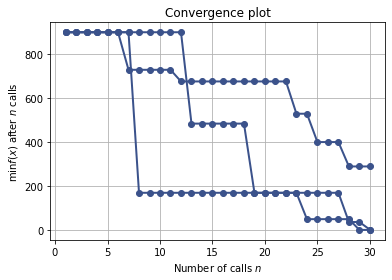

In [297]:
# train the model on the test data and print results
scores_svm_red_nf, best_parameters_svm_red_nf, mis_classified_svm_red_nf = nested_cv_svm_nf(X_df_red, labels, 1)

print('The results for svm with test examples:')
print(scores_svm_red_nf)
print(best_parameters_svm_red_nf)
print(np.mean(np.asarray(scores_svm_red_nf), axis=0))
print(mis_classified_svm_red_nf)

Best Parameters: [0.44832358822621804]
Best Parameters: [6.203132958797185]
Best Parameters: [0.22068324331379455]
Best Parameters: [10.53822354898137]
Best Parameters: [0.7294762062030326]
Best Parameters: [1.4861776775650348]
Best Parameters: [0.2571882998453008]
Best Parameters: [0.2510708036989323]
Best Parameters: [0.8264528691006222]


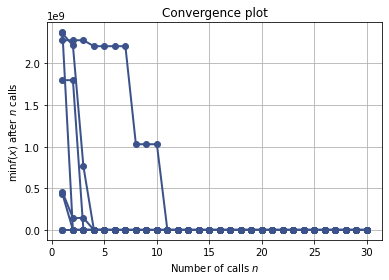

In [133]:
# train the model on full dataset

scores_svm_nf, best_parameters_svm_nf, mis_classified_svm_nf = nested_cv_svm_nf(X_df, labels, 3)
scores_svm_no75_nf, best_parameters_svm_no75_nf, mis_classified_svm_no75_nf = nested_cv_svm_nf(X_df_no75, labels_no75, 3)


In [134]:
# print results

print('The results for svm with all 63 examples:')
print(scores_svm_nf)
print(best_parameters_svm_nf)
print(np.mean(np.asarray(scores_svm_nf), axis=0))
print(mis_classified_svm_nf)

print('The results for svm without patient 75:')
print(scores_svm_no75_nf)
print(best_parameters_svm_no75_nf)
print(np.mean(np.asarray(scores_svm_no75_nf), axis=0))
print(mis_classified_svm_no75_nf)

The results for svm with test examples:
[(0.86, 1.0, 0.73), (0.9, 0.91, 0.91), (0.9, 0.89, 0.89)]
[[100.0], [38.67875438766363], [100.0]]
[0.88666667 0.93333333 0.84333333]
[{'Con_067': 'fp', 'Con_165a': 'fp', 'Con_206': 'fp'}, {'Con_079': 'fp', 'Inf075': 'fn'}, {'Con_087a': 'fp', 'Inf_149': 'fn'}]
The results for svm with all 63 examples:
[(1.0, 1.0, 1.0), (0.95, 1.0, 0.91), (0.95, 0.89, 1.0), (0.86, 1.0, 0.75), (0.86, 1.0, 0.77), (0.86, 0.89, 0.8), (0.81, 0.86, 0.67), (0.86, 0.89, 0.8), (1.0, 1.0, 1.0)]
[[0.6311385118212467], [0.5181795686122717], [0.3003907364634254], [4.401180517316189], [0.37200974601608905], [0.5512325780234016], [0.5095098606265706], [2.0056949255899474], [0.3111031128399527]]
[0.90555556 0.94777778 0.85555556]
[{}, {'Con_087a': 'fp'}, {'Inf075': 'fn'}, {'Con_021': 'fp', 'Con_029': 'fp', 'Con_040': 'fp'}, {'Con_087a': 'fp', 'Con_165a': 'fp', 'Con_206': 'fp'}, {'Con_071': 'fp', 'Con_079': 'fp', 'Inf075': 'fn'}, {'Con_067': 'fp', 'Con_071': 'fp', 'Con_079': 'fp', 

Best Parameters: [0.18125853961866795]


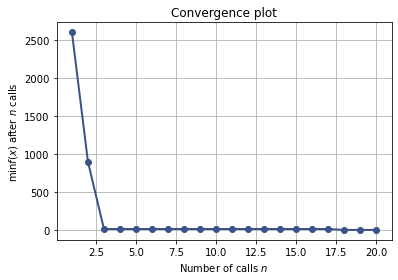

In [136]:
# re-training the final model on the full dataset to identify the selected features    
# extract coefficients based on model type

final_svm_nf, best_param_svm_nf = train_lr_baysian_nf(X_df, labels)

In [168]:
selected_features_svm_nf = final_svm_nf.coef_[0]
selected_gene_svm_nf_final = identify_genes_from_coefs(selected_features_svm_nf, X_df, gene_df)


The number of selected genes is:  30


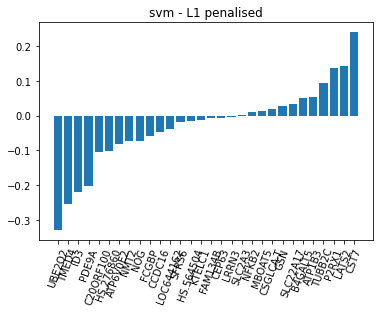

In [169]:
print('The number of selected genes is:  '+str(len(selected_gene_svm_nf_final)))
plot_genes(selected_gene_svm_nf_final, model='svm - L1 penalised')